## Preparing notebook

In [1]:
! pip install keras --upgrade
! pip install tensorflow --upgrade
! pip install arabic_reshaper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tenso

## Import libraries

In [2]:
import os
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from bidi.algorithm import get_display
import arabic_reshaper
from arabic_reshaper import reshape
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier

## Loading data

In [3]:
batch_size = 64
raw_train_ds = keras.utils.text_dataset_from_directory(
    '/kaggle/input/persian-news-preprocessed/datas',
    label_mode='categorical',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337,
    shuffle=True
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    '/kaggle/input/persian-news-preprocessed/datas',
    label_mode='categorical',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=1337,
    shuffle=True
)


print(f'Number of batches in raw_train_ds: {raw_train_ds.cardinality()}')
print(f'Number of batches in raw_val_ds: {raw_val_ds.cardinality()}')

Found 10999 files belonging to 11 classes.
Using 8800 files for training.
Found 10999 files belonging to 11 classes.
Using 2199 files for validation.
Number of batches in raw_train_ds: 138
Number of batches in raw_val_ds: 35


In [4]:
max_features = 50000
embedding_dim = 256
sequence_length = 250
num_classes = 11
num_heads = 8
units = 128
epochs = 5

vectorize_layer = keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [5]:
def vectorize_text(text, label):
    return vectorize_layer(text), label


train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)

In [6]:
trains = [np.argmax(y, axis=1) for x, y in train_ds]
vals = [np.argmax(y, axis=1) for x, y in val_ds]
train_label = list()
for l in trains:
    train_label.extend(l)
val_label = list()
for l in vals:
    val_label.extend(l)
labels = [get_display(reshape(x)) for x in list(raw_train_ds.class_names)]

## DL

### Configuration

In [7]:
metrics = ['accuracy',
           keras.metrics.F1Score(average='weighted')]

### Convolutional base model

In [8]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')


x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)


x = layers.Conv1D(units, 7, padding='valid', activation='relu', strides=3, name='Conv1D1')(x)
x = layers.Conv1D(units, 7, padding='valid', activation='relu', strides=3, name='Conv1D2')(x)
x = layers.GlobalMaxPooling1D(name='GlobalMaxPooling1D')(x)


x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_1 = keras.Model(inputs, predictions)
model_1.summary()
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, None, 256)      │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D1 (Conv1D)                │ (None, None, 128)      │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D2 (Conv1D)                │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalMaxPooling1D              │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,162,251 (50.21 MB)

 Trainable params: 13,162,251 (50.21 MB)

 Non-trainable params: 0 (0.00 B)

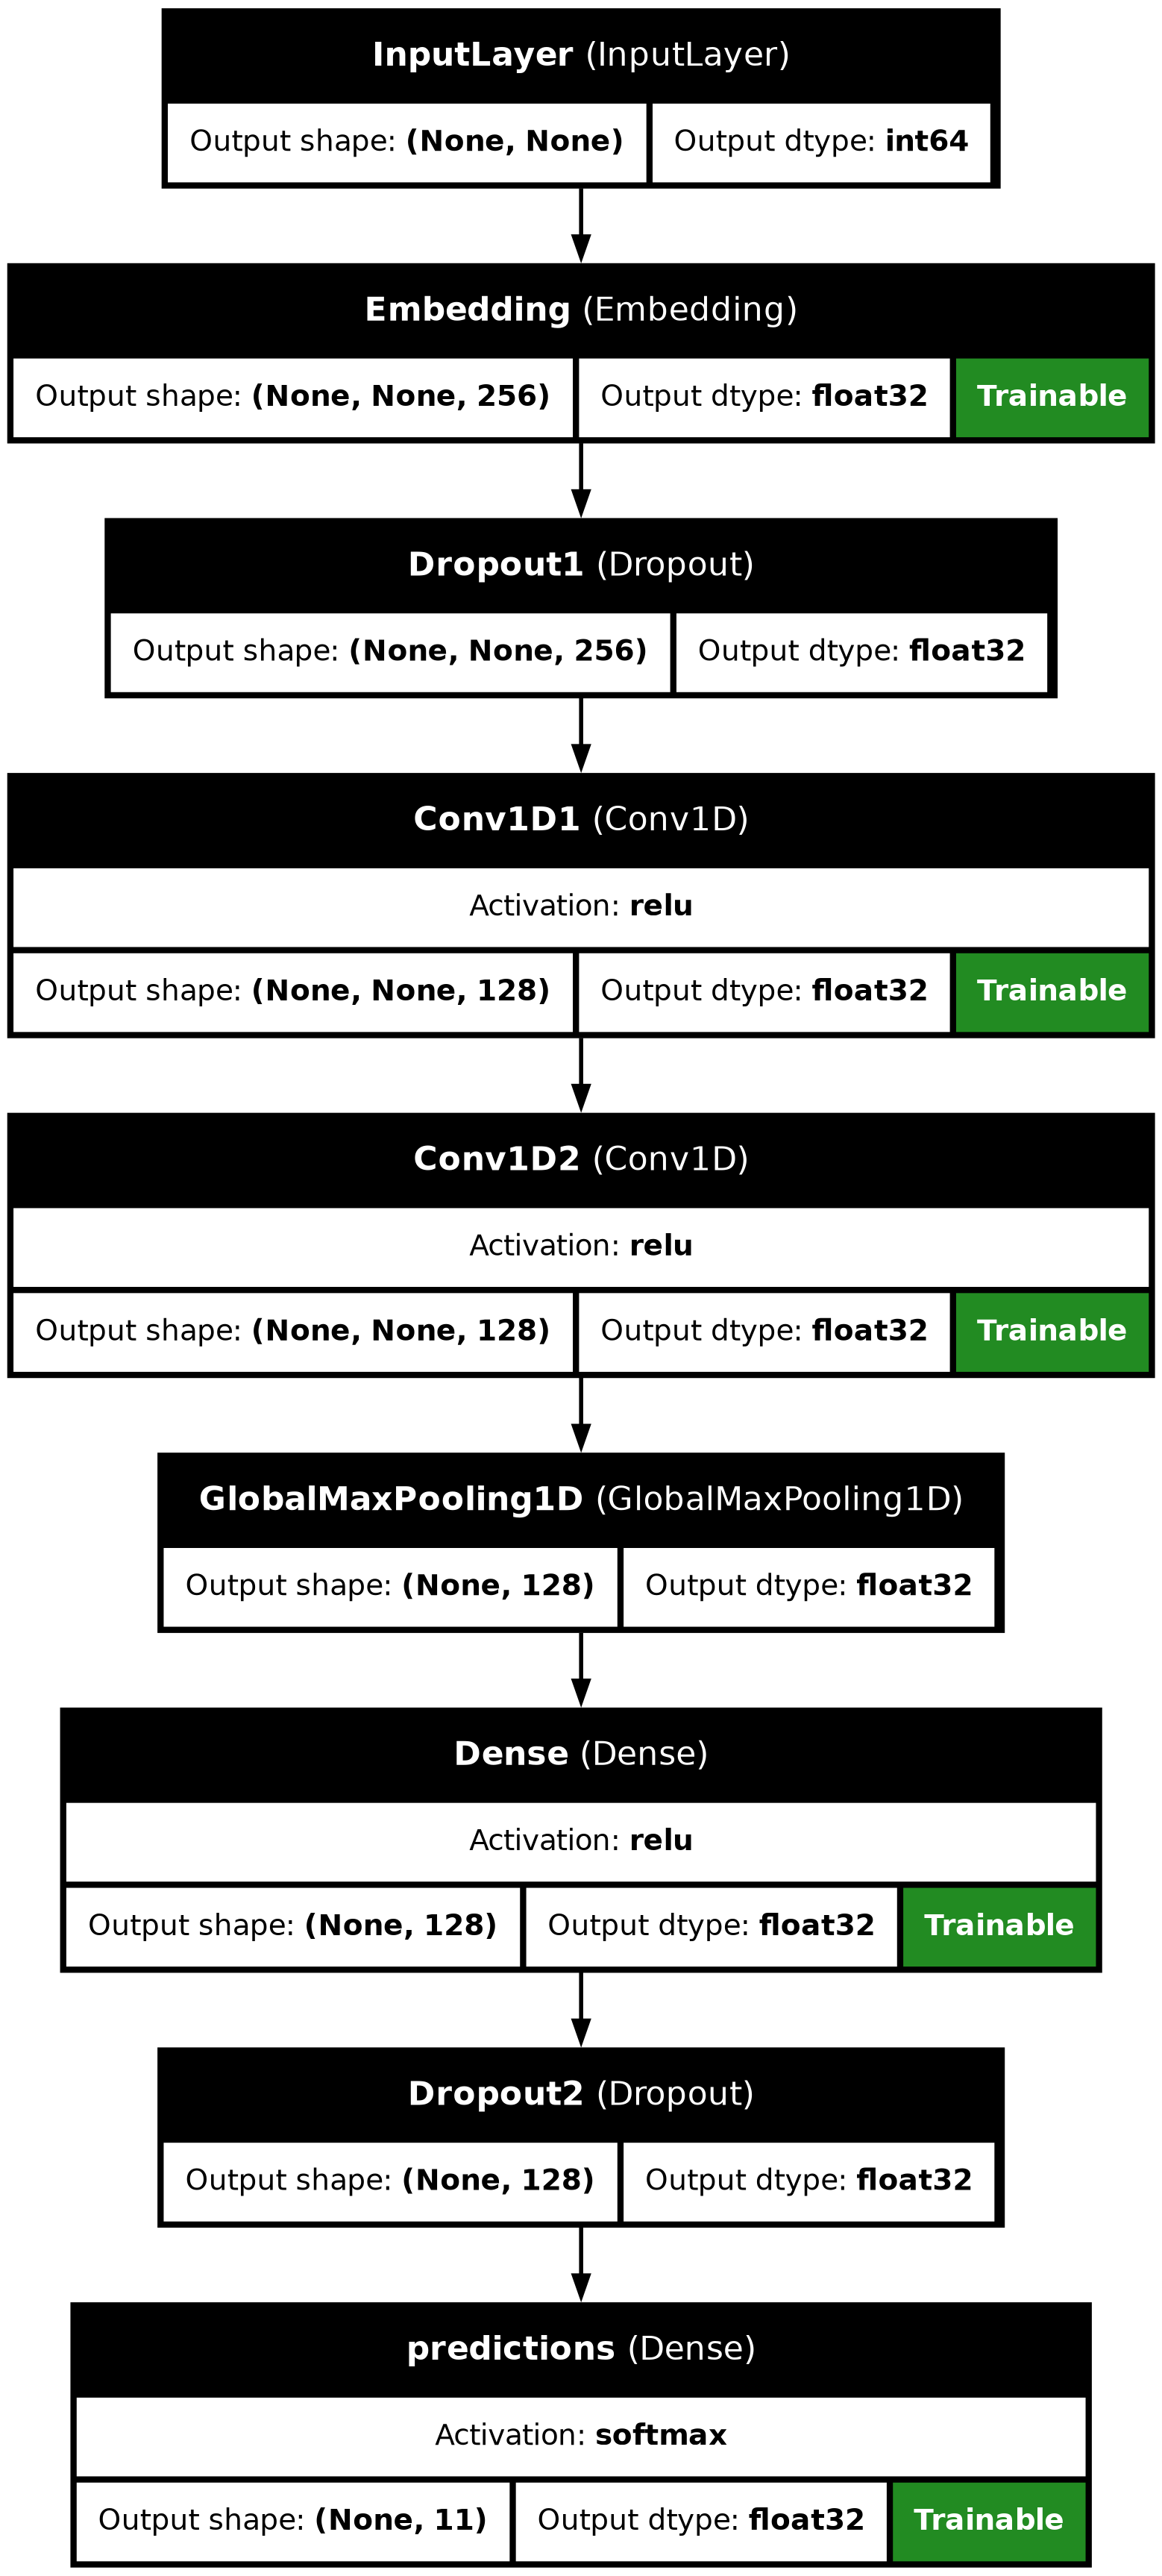

In [9]:
keras.utils.plot_model(
    model_1,
    to_file="model_1.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True)

### LSTM base model

In [10]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')
x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.LSTM(units, activation='relu', name='LSTM')(x)

x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_2 = keras.Model(inputs, predictions)
model_2.summary()
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, None, 256)      │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,015,051 (49.65 MB)

 Trainable params: 13,015,051 (49.65 MB)

 Non-trainable params: 0 (0.00 B)

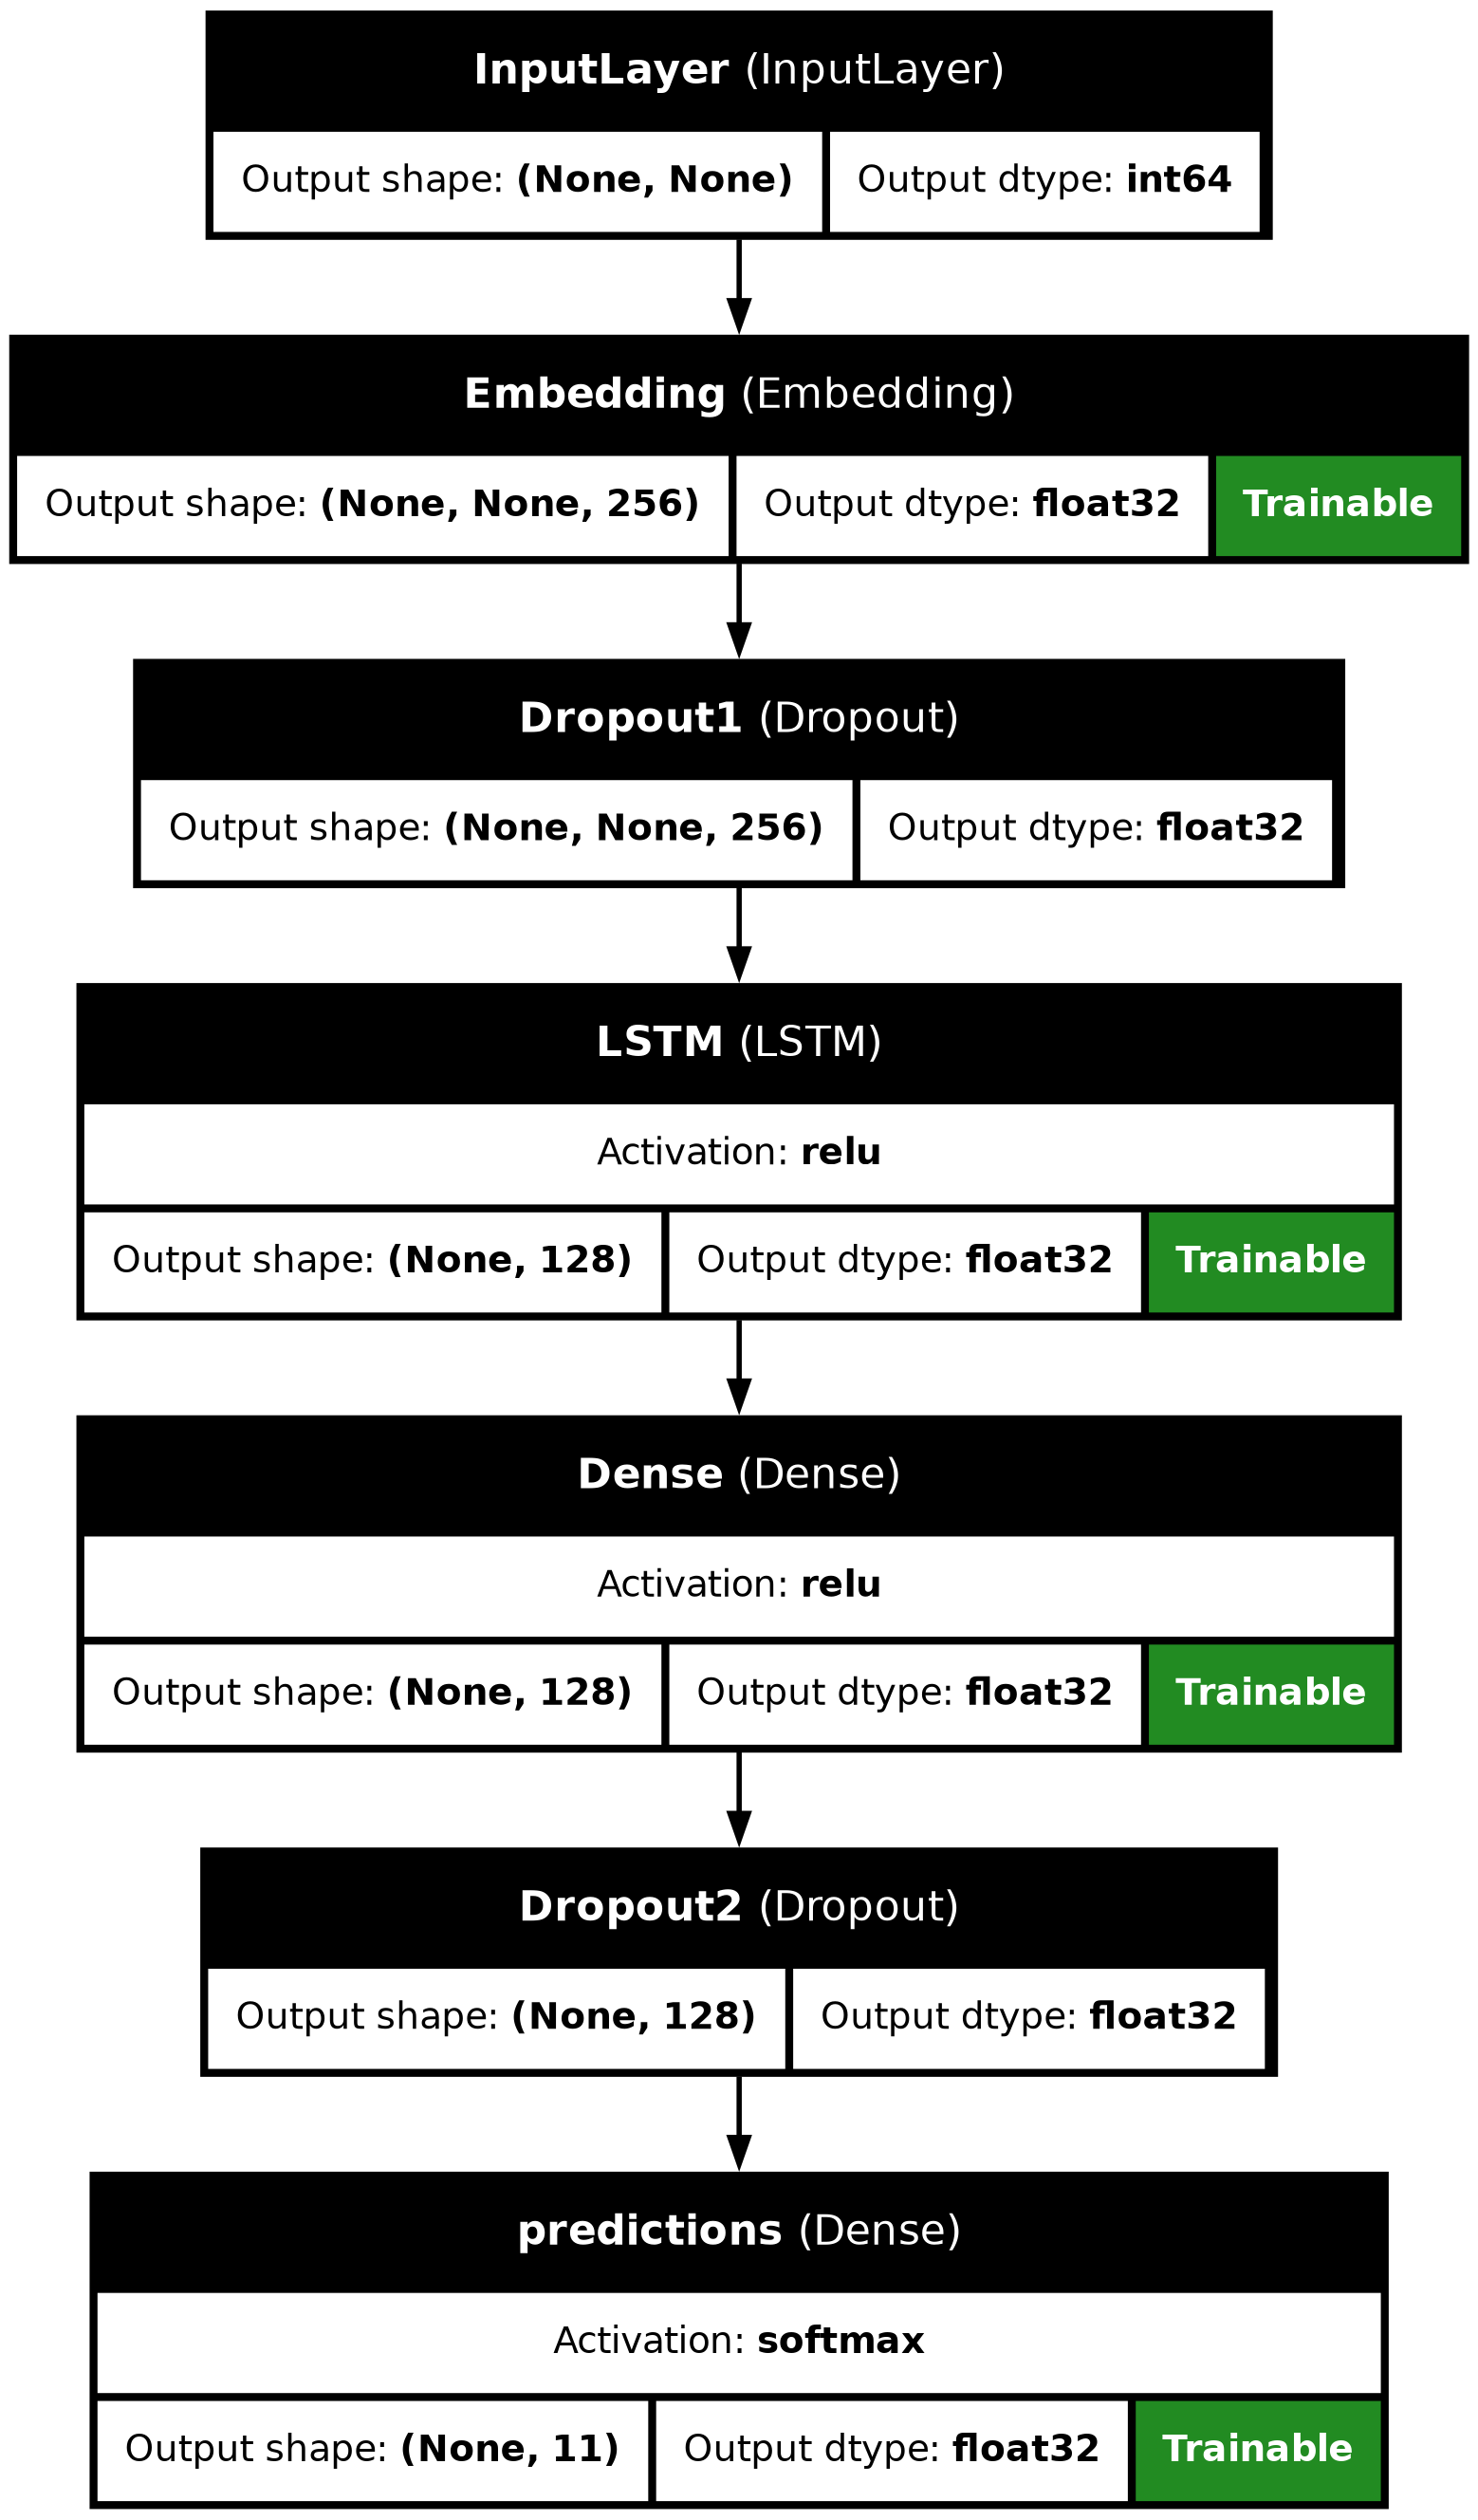

In [11]:
keras.utils.plot_model(
    model_2,
    to_file="model_2.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True)

### Bidirectional(LSTM units) base model

In [12]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')
x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM1'), name='Bidirectional1')(x)
x = layers.Bidirectional(layers.LSTM(units, name='LSTM2'), name='Bidirectional2')(x)

x = layers.Dense(units, activation='relu', name='Dense1')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_3 = keras.Model(inputs, predictions)
model_3.summary()
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding (Embedding)           │ (None, None, 256)      │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional1 (Bidirectional)  │ (None, None, 256)      │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bidirectional2 (Bidirectional)  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,622,795 (51.97 MB)

 Trainable params: 13,622,795 (51.97 MB)

 Non-trainable params: 0 (0.00 B)

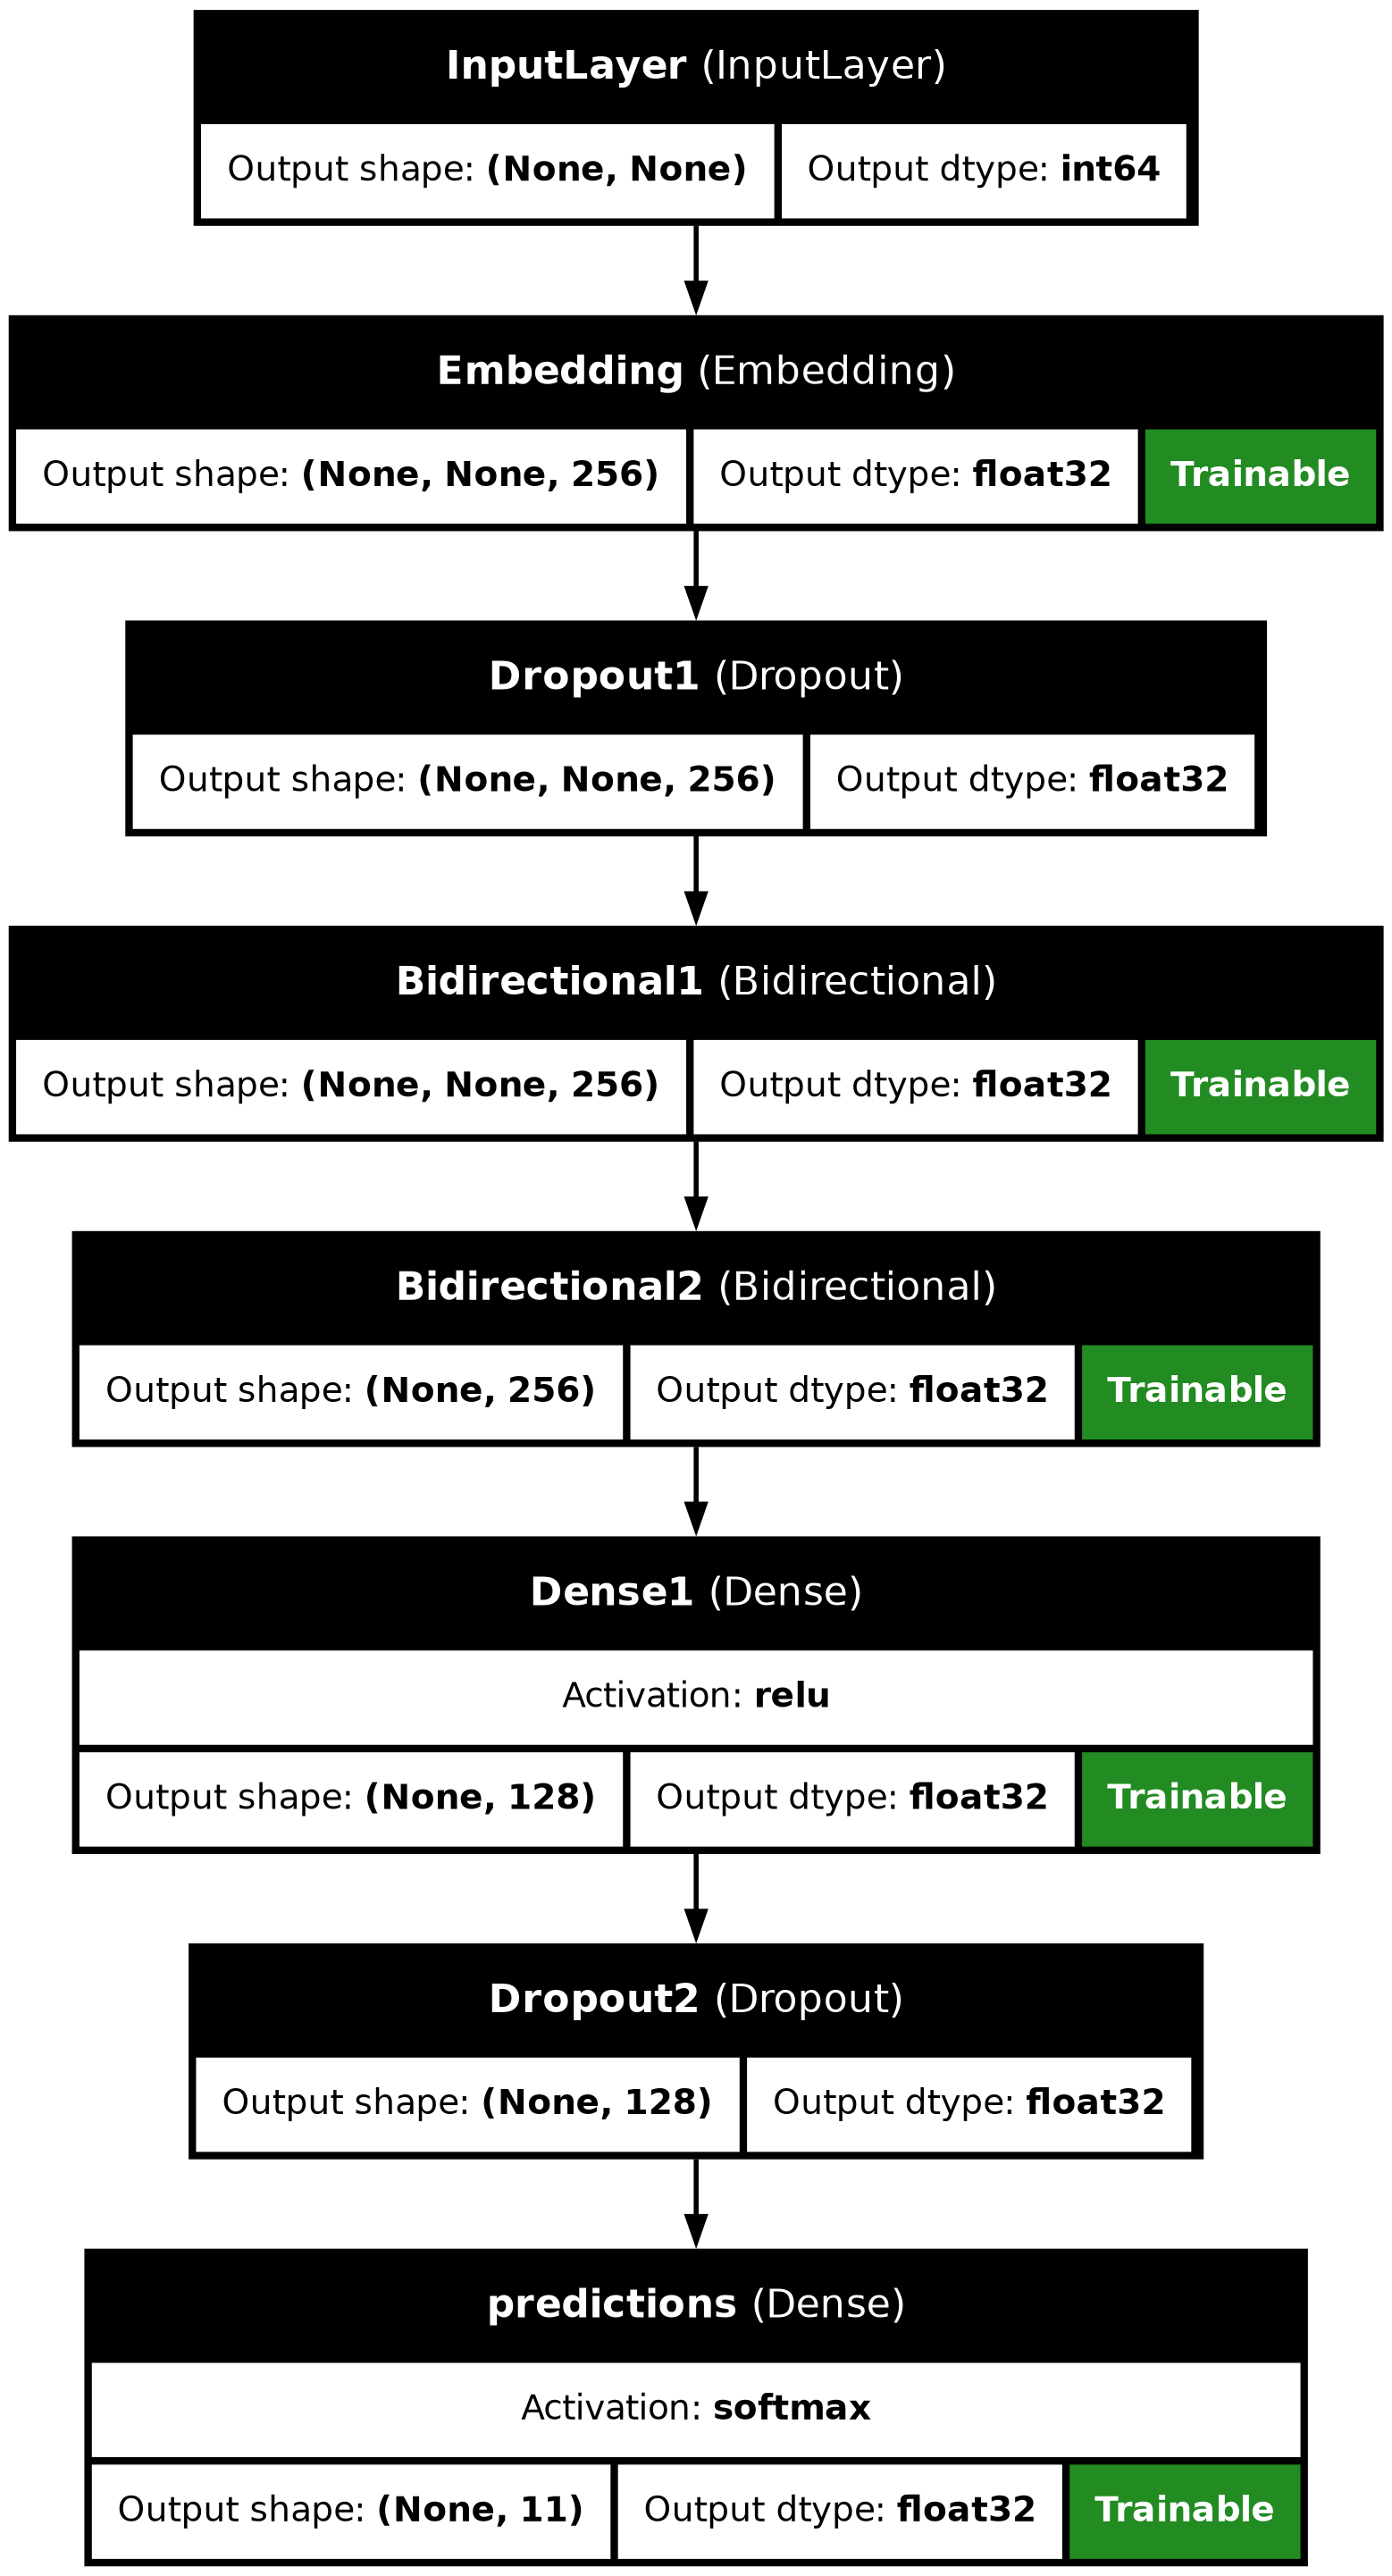

In [13]:
keras.utils.plot_model(
    model_3,
    to_file="model_3.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True)

### Attention + GRU base model

In [14]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, name='Attention')(query=x, value=x)
x = layers.GRU(units, return_sequences=True, activation='tanh', name='GRU')(x)
x = layers.GlobalMaxPool1D(name='GlobalMaxPool1D')(x)

x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_4 = keras.Model(inputs, predictions)
model_4.summary()
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, None, 256) │ 12,800,000 │ InputLayer[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout1 (Dropout)  │ (None, None, 256) │          0 │ Embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention           │ (None, None, 256) │  2,103,552 │ Dropout1[0][0],   │
│ (MultiHeadAttentio… │                   │            │ Dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU (GRU)           │ (None, None, 128) │    148,224 │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalMaxPool1D     │ (None, 128)       │          0 │ GRU[0][0]         │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense (Dense)       │ (None, 128)       │     16,512 │ GlobalMaxPool1D[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout2 (Dropout)  │ (None, 128)       │          0 │ Dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 11)        │      1,419 │ Dropout2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,069,707 (57.49 MB)

 Trainable params: 15,069,707 (57.49 MB)

 Non-trainable params: 0 (0.00 B)

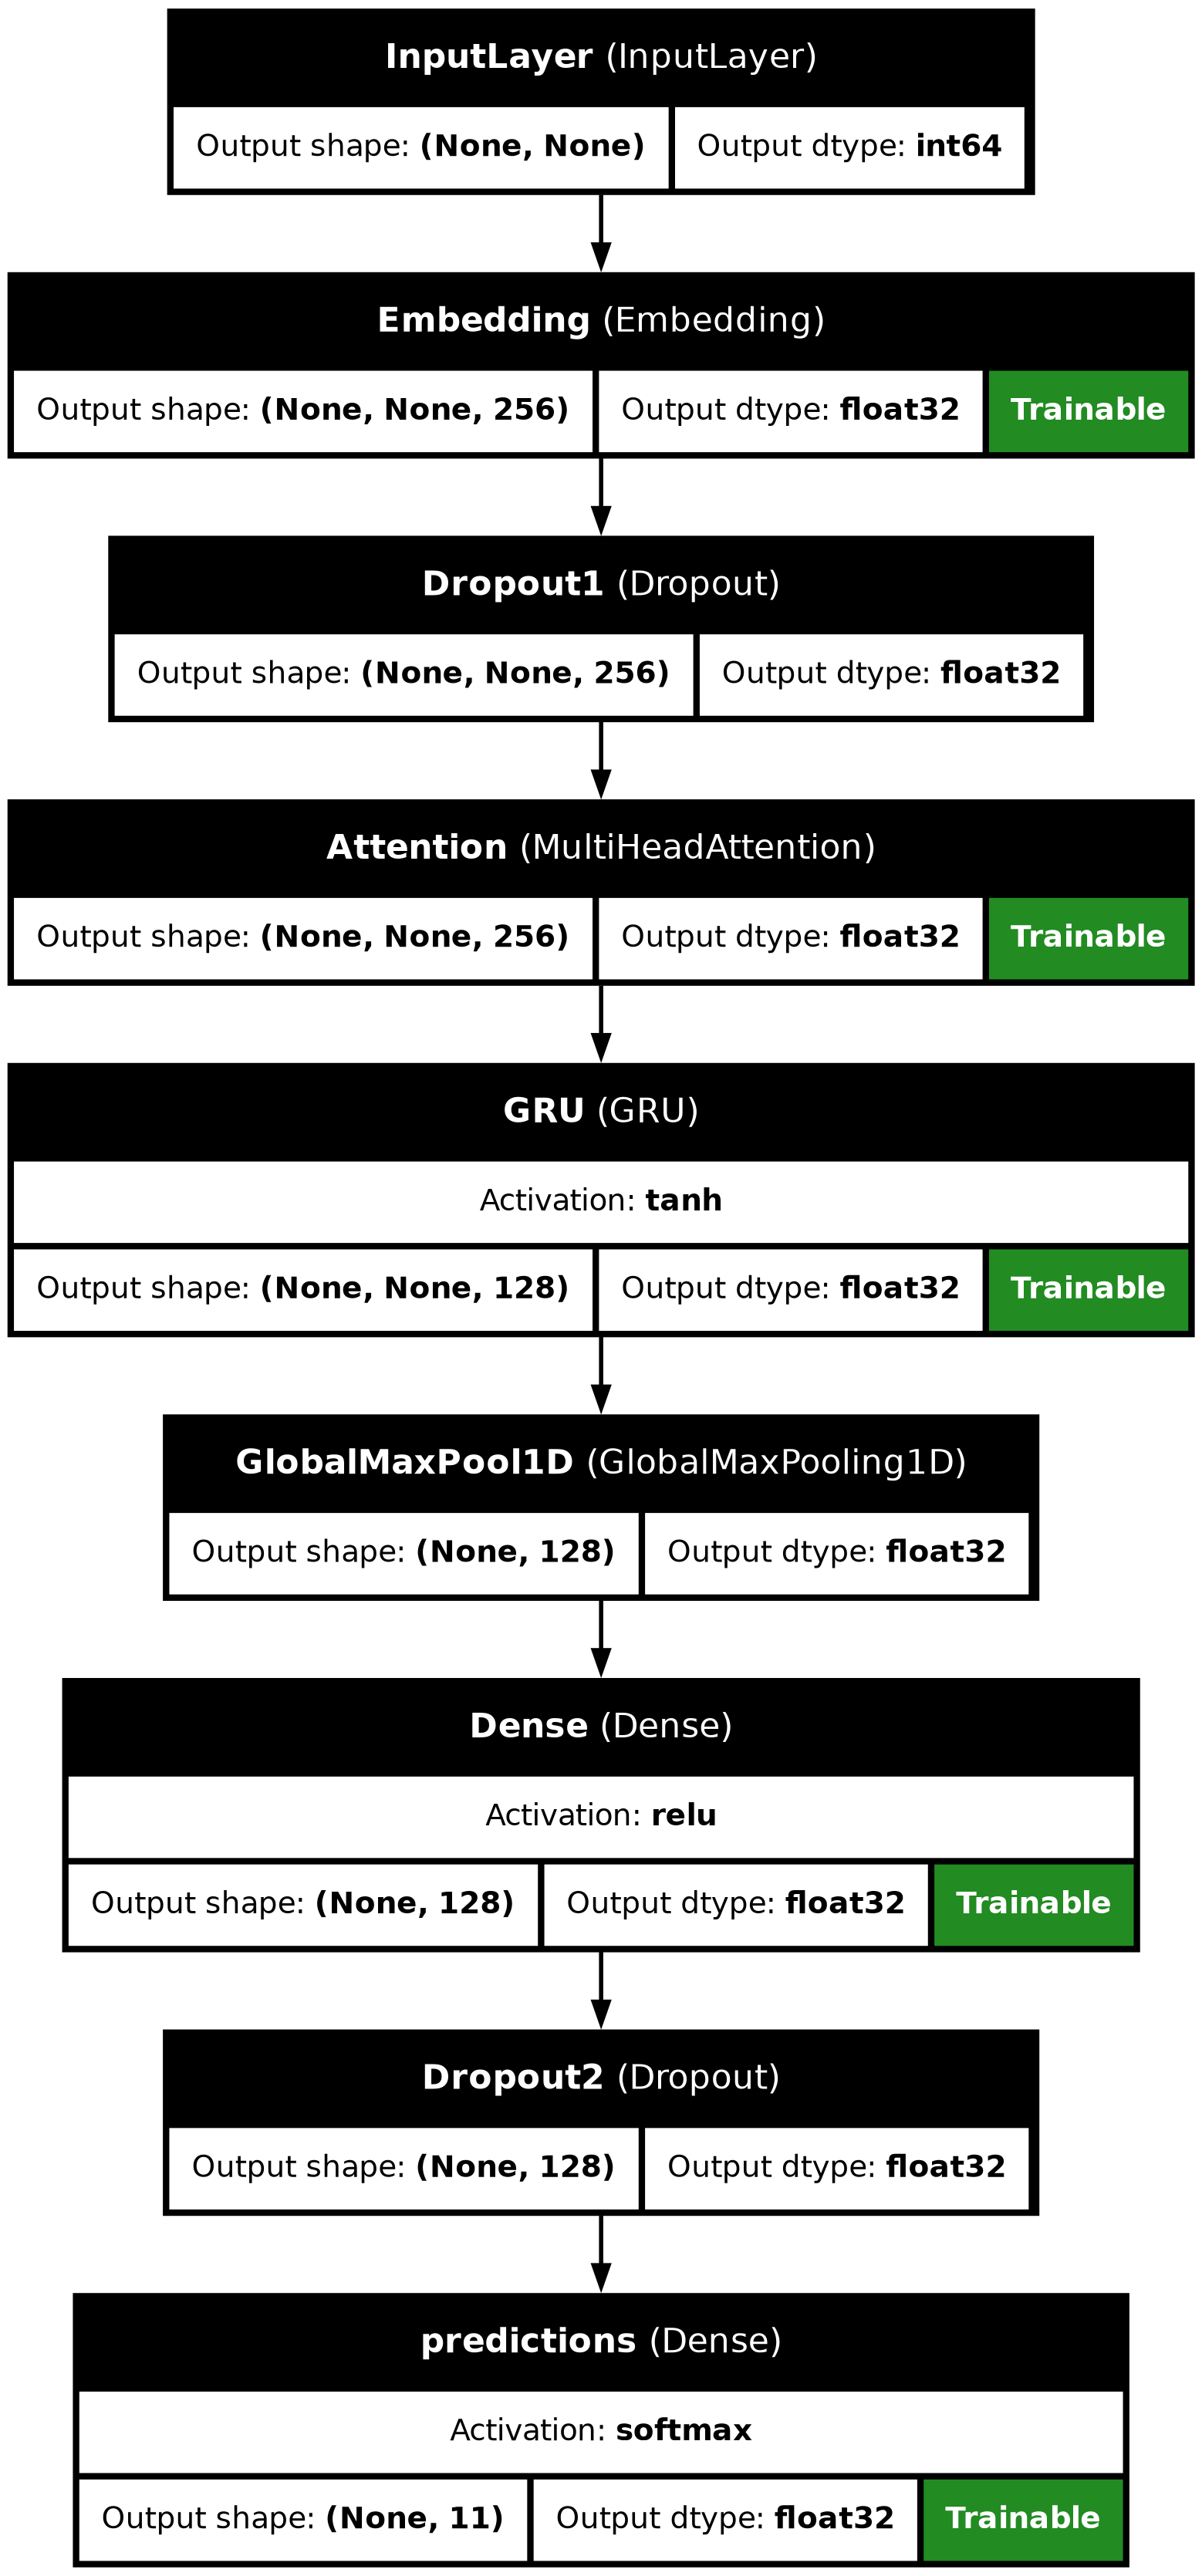

In [15]:
keras.utils.plot_model(
    model_4,
    to_file="model_4.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True)

### Attention + Bidirectional(LSTM units) base model

In [16]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

x = layers.Embedding(max_features, embedding_dim, name='Embedding')(inputs)
x = layers.Dropout(0.5, name='Dropout1')(x)

x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, name='Attention')(query=x, value=x)

x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM1'), name='Bidirectional1')(x)
x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, name='LSTM2'), name='Bidirectional2')(x)
x = layers.GlobalAveragePooling1D(name='GlobalAveragePooling1D')(x)

x = layers.Dense(units, activation='relu', name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout2')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_5 = keras.Model(inputs, predictions)
model_5.summary()
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, None, 256) │ 12,800,000 │ InputLayer[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout1 (Dropout)  │ (None, None, 256) │          0 │ Embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention           │ (None, None, 256) │  2,103,552 │ Dropout1[0][0],   │
│ (MultiHeadAttentio… │                   │            │ Dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bidirectional1      │ (None, None, 256) │    394,240 │ Attention[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bidirectional2      │ (None, None, 256) │    394,240 │ Bidirectional1[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobalAveragePooli… │ (None, 256)       │          0 │ Bidirectional2[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense (Dense)       │ (None, 128)       │     32,896 │ GlobalAveragePoo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout2 (Dropout)  │ (None, 128)       │          0 │ Dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 11)        │      1,419 │ Dropout2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,726,347 (59.99 MB)

 Trainable params: 15,726,347 (59.99 MB)

 Non-trainable params: 0 (0.00 B)

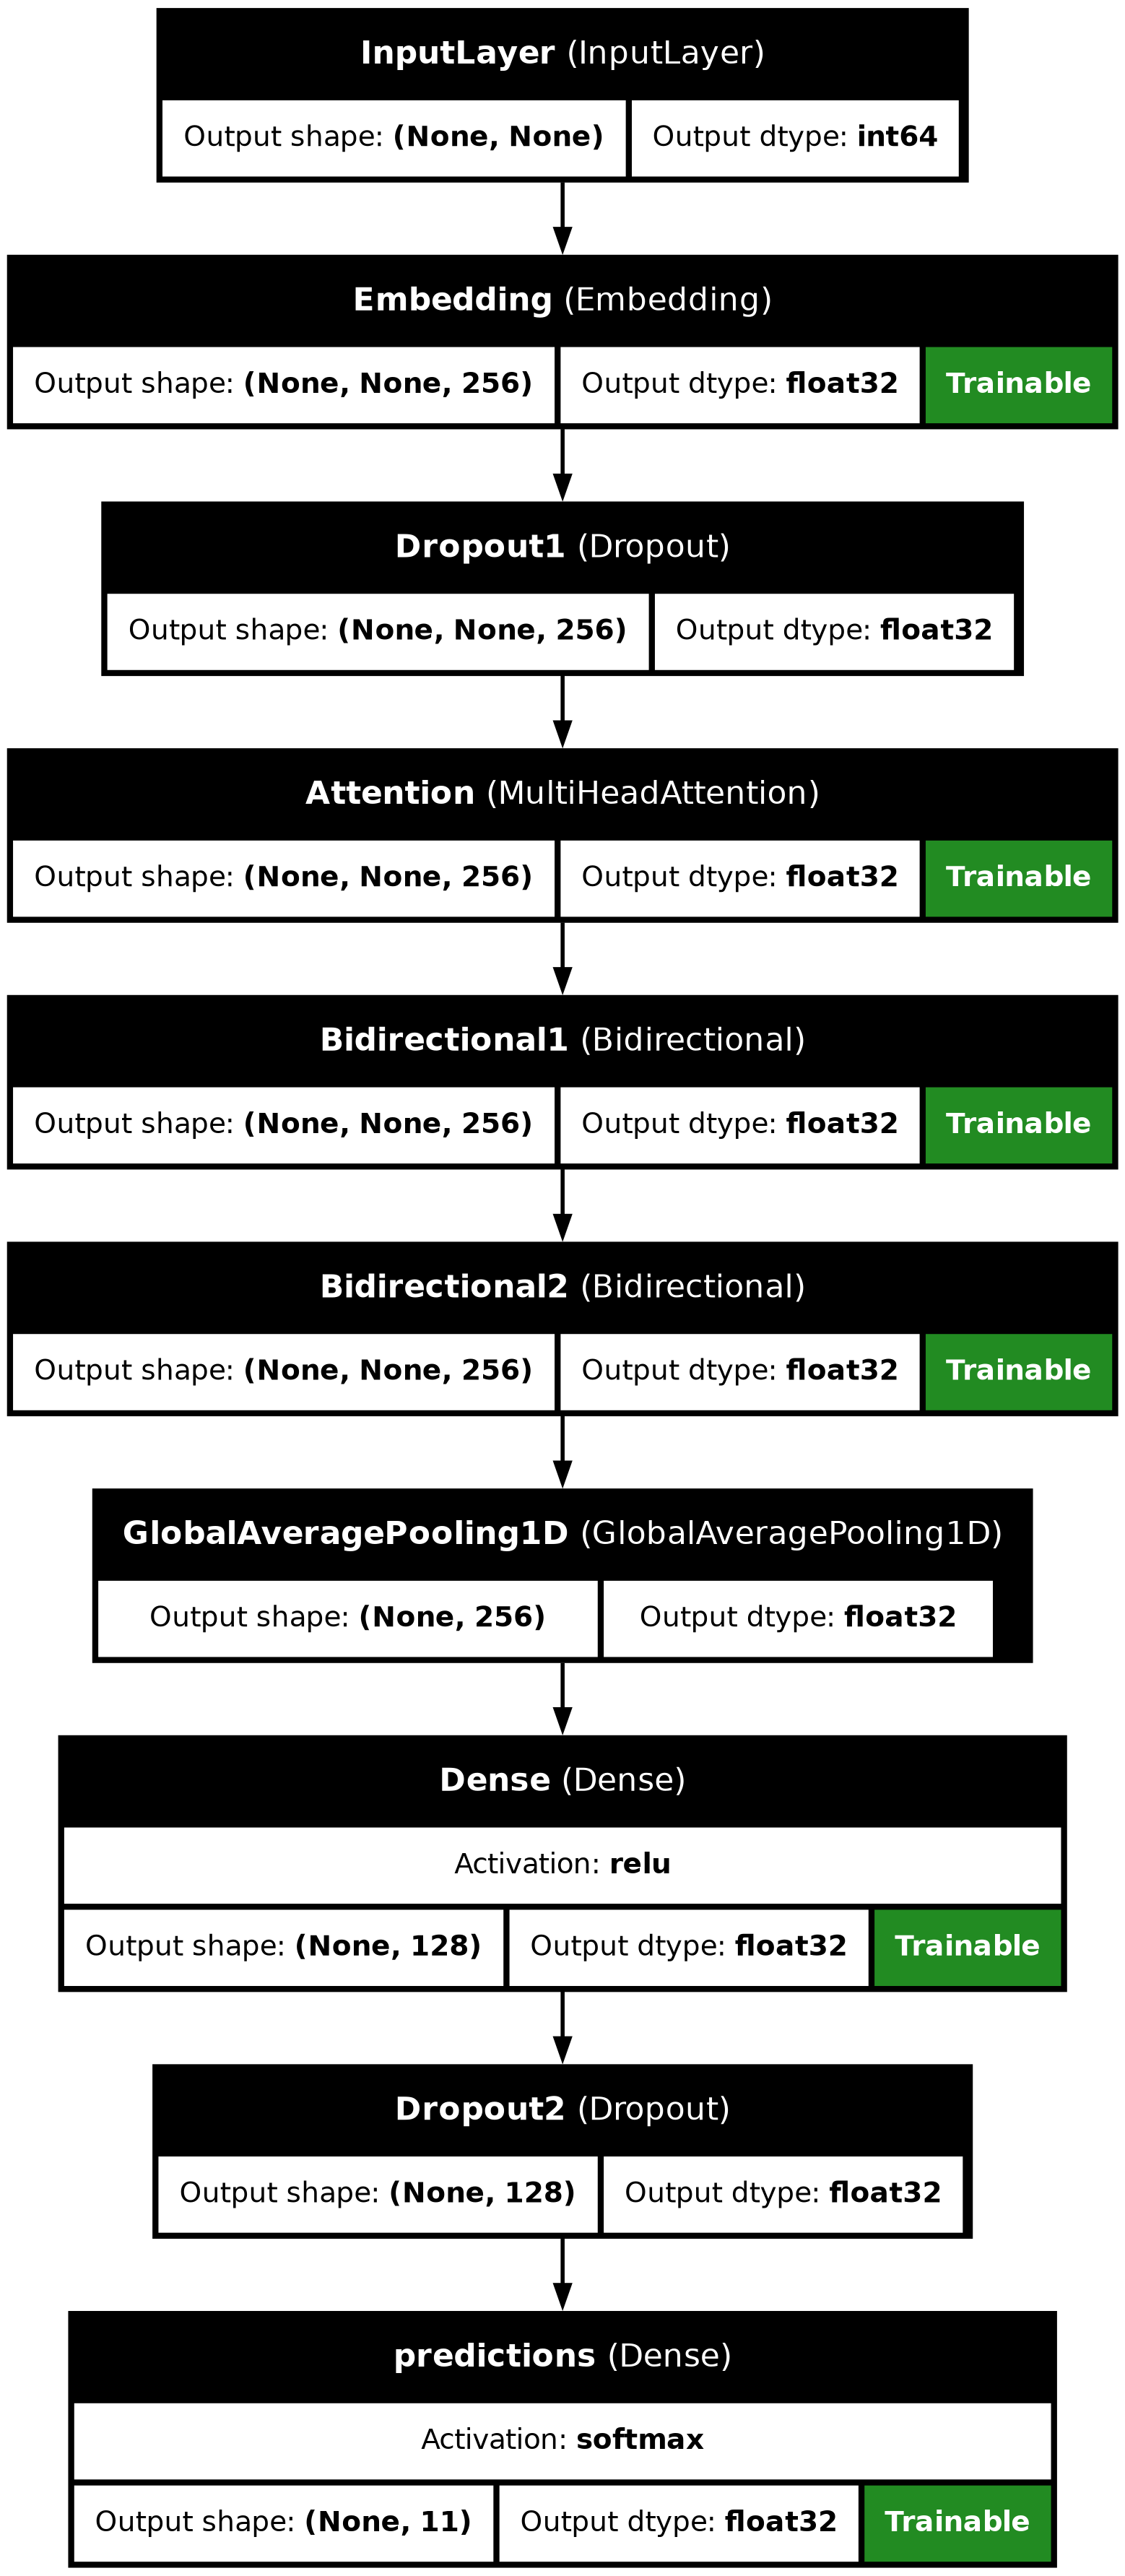

In [17]:
keras.utils.plot_model(
    model_5,
    to_file="model_5.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True)

### Transfomer + Attention base model

#### Transformer definition

In [18]:
class Transformer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.Attention = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.FeedForward = keras.models.Sequential([
            layers.Dense(units=self.ff_dim, activation='relu'),
            layers.Dense(units=self.embed_dim)
        ])
        self.Normalization_1 = layers.LayerNormalization(epsilon=1e-6)
        self.Normalization_2 = layers.LayerNormalization(epsilon=1e-6)
        self.Droupout_1 = layers.Dropout(self.rate)
        self.Droupout_2 = layers.Dropout(self.rate)
    def call(self, inputs):
        att_out = self.Attention(inputs, inputs)
        att_out = self.Droupout_1(att_out)
        out_1 = self.Normalization_1(inputs + att_out)
        out_ff = self.FeedForward(out_1)
        out_ff = self.Droupout_2(out_ff)
        out = self.Normalization_2(out_1 + out_ff)
        return out

In [19]:
class PositionalTokenEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.tokenEmbeding = layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim)
        self.positionalEmbeding = layers.Embedding(input_dim=self.maxlen, output_dim=self.embed_dim)
    def call(self, inputs):
        positions = np.arange(start=0, stop=self.maxlen, step=1)
        positions = self.positionalEmbeding(positions)
        tokens = self.tokenEmbeding(inputs)
        return positions + tokens

#### Create model

In [20]:
inputs = keras.Input(shape=(None,), dtype='int64', name='InputLayer')

embedding_layer = PositionalTokenEmbedding(sequence_length, max_features, embedding_dim)
x = embedding_layer(inputs)

transformer_layer_1 = Transformer(embedding_dim, num_heads, units)
x = transformer_layer_1(x)
transformer_layer_2 = Transformer(embedding_dim, num_heads, units)
x = transformer_layer_2(x)

x = layers.GlobalAveragePooling1D(name = 'GlobalAveragePooling1D')(x)

x = layers.Dense(units, activation="relu", name='Dense')(x)
x = layers.Dropout(0.5, name='Dropout1')(x)

predictions = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model_6 = keras.Model(inputs, predictions)
model_6.summary()
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_token_embedding      │ (None, 250, 256)       │    12,864,000 │
│ (PositionalTokenEmbedding)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer (Transformer)       │ (None, 250, 256)       │     2,170,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_1 (Transformer)     │ (None, 250, 256)       │     2,170,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalAveragePooling1D          │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,239,307 (65.76 MB)

 Trainable params: 17,239,307 (65.76 MB)

 Non-trainable params: 0 (0.00 B)

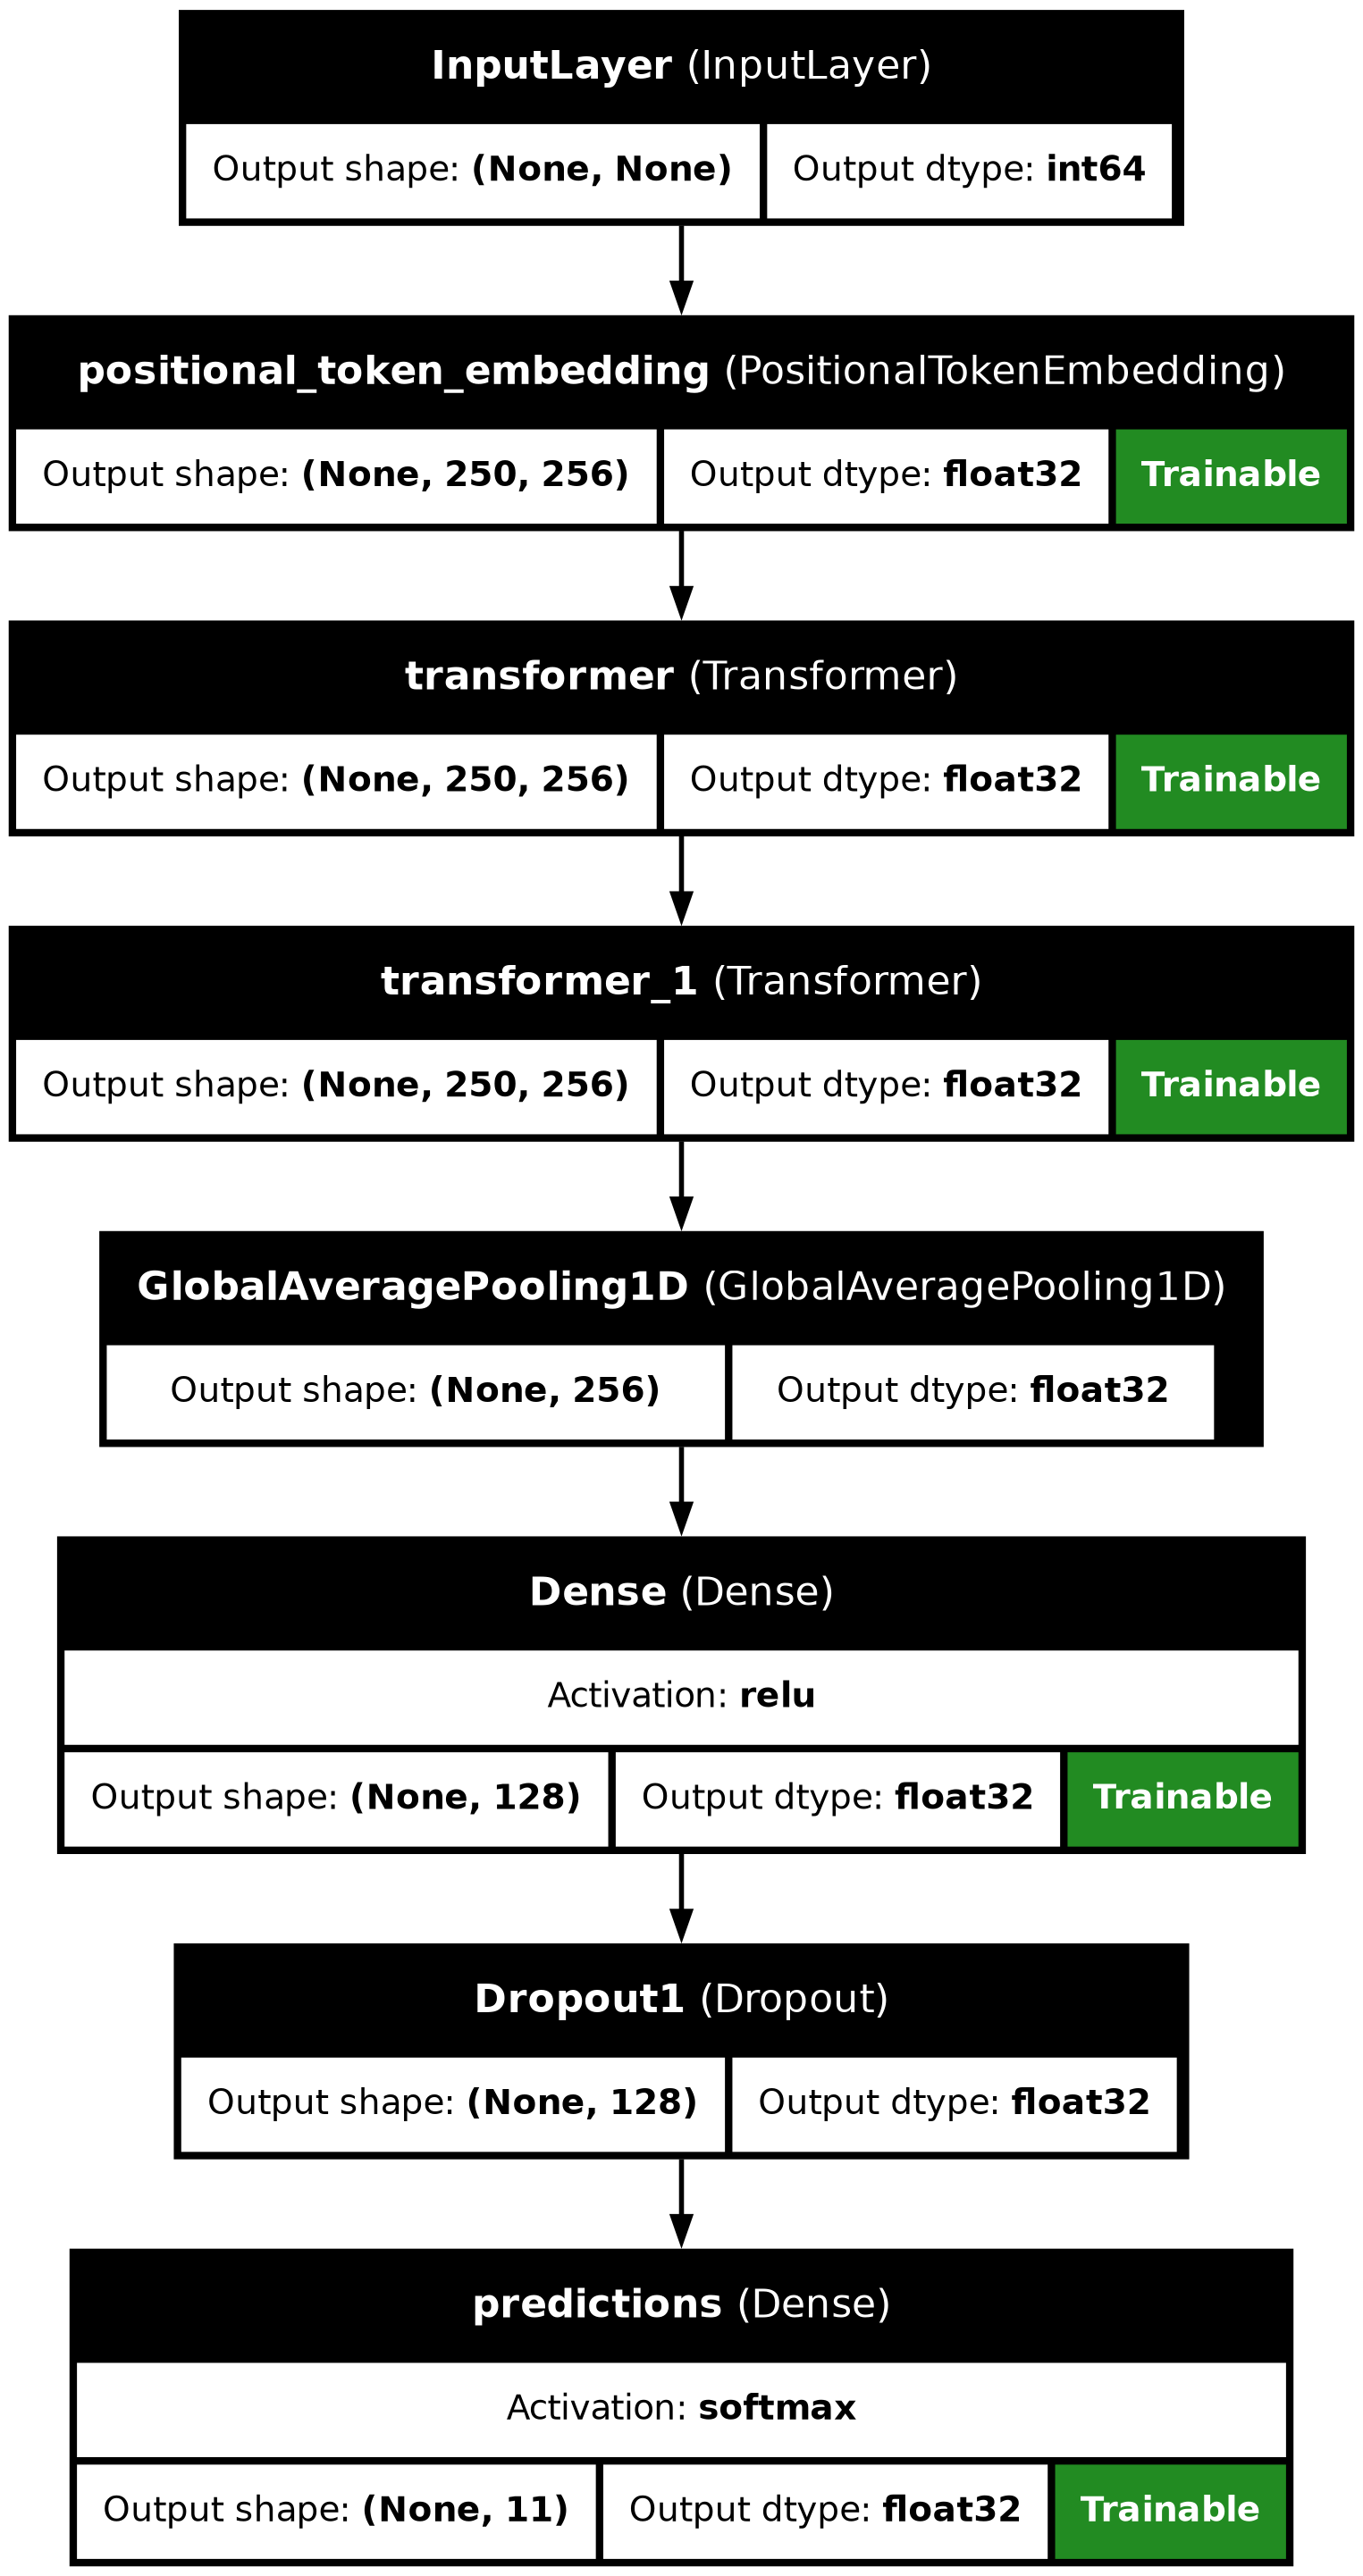

In [21]:
keras.utils.plot_model(
    model_6,
    to_file="model_6.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True)

### Models training

#### model_1

In [22]:
history_1 = model_1.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5


I0000 00:00:1713782928.060630      93 service.cc:145] XLA service 0x5b36938a9190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713782928.060669      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1713782928.060673      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 13/138 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0864 - f1_score: 0.0641 - loss: 2.4058

I0000 00:00:1713782933.105064      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.1054 - f1_score: 0.0937 - loss: 2.3855 - val_accuracy: 0.4197 - val_f1_score: 0.3207 - val_loss: 1.7151
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5163 - f1_score: 0.4882 - loss: 1.3519 - val_accuracy: 0.7885 - val_f1_score: 0.7722 - val_loss: 0.6360
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8270 - f1_score: 0.8224 - loss: 0.5435 - val_accuracy: 0.8204 - val_f1_score: 0.8217 - val_loss: 0.6073
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9125 - f1_score: 0.9116 - loss: 0.2833 - val_accuracy: 0.8245 - val_f1_score: 0.8274 - val_loss: 0.6593
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9570 - f1_score: 0.9569 - loss: 0.1501 - val_accuracy: 0.8122 - val_f1_score: 0.8179 - val_loss: 0.7802


In [23]:
loss, accuracy, f1 = model_1.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8168 - f1_score: 0.8238 - loss: 0.7270
Final loss :0.78 
Final accuracy 0.81 
Final f1 0.82


In [24]:
train_label_predict = np.argmax(model_1.predict(train_ds), axis=1)
print('model_1 result on train data\n', classification_report(y_pred=train_label_predict, y_true=train_label))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
model_1 result on train data
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       783
           1       0.98      0.95      0.97       814
           2       0.99      0.99      0.99       782
           3       1.00      1.00      1.00       801
           4       0.99      1.00      0.99       805
           5       1.00      0.98      0.99       786
           6       0.99      0.99      0.99       811
           7       0.99      1.00      0.99       797
           8       1.00      1.00      1.00       808
           9       0.99      1.00      1.00       807
          10       1.00      1.00      1.00       806

    accuracy                           0.99      8800
   macro avg       0.99      0.99      0.99      8800
weighted avg       0.99      0.99      0.99      8800



In [25]:
test_label_predict = np.argmax(model_1.predict(val_ds), axis=1)
print('model_1 result on test data\n', classification_report(y_pred=test_label_predict, y_true=val_label))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
model_1 result on test data
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       217
           1       0.46      0.66      0.54       186
           2       0.79      0.80      0.79       218
           3       0.93      0.92      0.93       199
           4       0.90      0.85      0.88       194
           5       0.70      0.69      0.69       214
           6       0.80      0.80      0.80       189
           7       0.83      0.78      0.80       203
           8       0.86      0.77      0.81       192
           9       0.94      0.88      0.91       193
          10       0.98      0.91      0.95       194

    accuracy                           0.81      2199
   macro avg       0.83      0.81      0.82      2199
weighted avg       0.83      0.81      0.82      2199



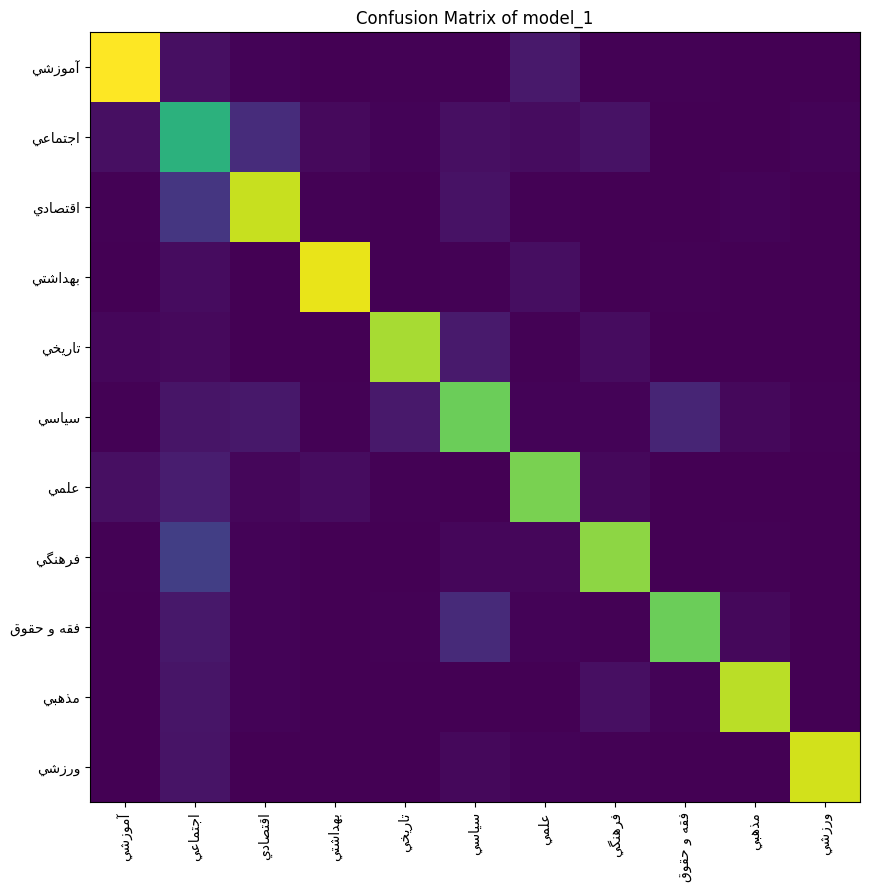

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=test_label_predict, y_true=val_label))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of model_1')
plt.show();

#### model_2

In [27]:
history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - accuracy: 0.0976 - f1_score: 0.4018 - loss: nan - val_accuracy: 0.0882 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0845 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0882 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0845 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0882 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0845 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0882 - val_f1_score: 0.0000e+00 - val_loss: nan
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0845 - f1_score: 0.0000e+00 - loss: nan - val_accuracy: 0.0882 - val_f1_score: 0.0000e+00 - val_loss: nan


In [28]:
loss, accuracy, f1 = model_2.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0912 - f1_score: 0.0000e+00 - loss: nan
Final loss :nan 
Final accuracy 0.09 
Final f1 0.00


In [29]:
train_label_predict = np.argmax(model_2.predict(train_ds), axis=1)
print('model_2 result on train data\n', classification_report(y_pred=train_label_predict, y_true=train_label))

138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
model_2 result on train data
               precision    recall  f1-score   support

           0       0.09      1.00      0.16       783
           1       0.00      0.00      0.00       814
           2       0.00      0.00      0.00       782
           3       0.00      0.00      0.00       801
           4       0.00      0.00      0.00       805
           5       0.00      0.00      0.00       786
           6       0.00      0.00      0.00       811
           7       0.00      0.00      0.00       797
           8       0.00      0.00      0.00       808
           9       0.00      0.00      0.00       807
          10       0.00      0.00      0.00       806

    accuracy                           0.09      8800
   macro avg       0.01      0.09      0.01      8800
weighted avg       0.01      0.09      0.01      8800



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
test_label_predict = np.argmax(model_2.predict(val_ds), axis=1)
print('model_2 result on test data\n', classification_report(y_pred=test_label_predict, y_true=val_label))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
model_2 result on test data
               precision    recall  f1-score   support

           0       0.10      1.00      0.18       217
           1       0.00      0.00      0.00       186
           2       0.00      0.00      0.00       218
           3       0.00      0.00      0.00       199
           4       0.00      0.00      0.00       194
           5       0.00      0.00      0.00       214
           6       0.00      0.00      0.00       189
           7       0.00      0.00      0.00       203
           8       0.00      0.00      0.00       192
           9       0.00      0.00      0.00       193
          10       0.00      0.00      0.00       194

    accuracy                           0.10      2199
   macro avg       0.01      0.09      0.02      2199
weighted avg       0.01      0.10      0.02      2199



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


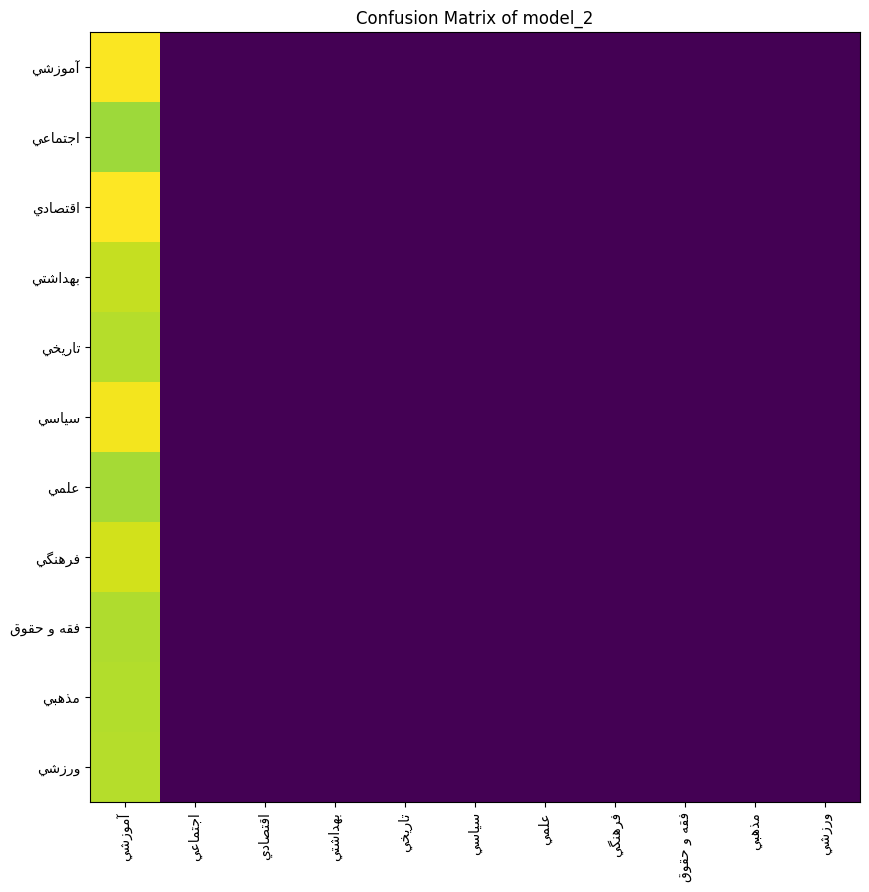

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=test_label_predict, y_true=val_label))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of model_2')
plt.show();

#### model_3

In [32]:
history_3 = model_3.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.3072 - f1_score: 0.2306 - loss: 1.9524 - val_accuracy: 0.7226 - val_f1_score: 0.7118 - val_loss: 0.8204
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7678 - f1_score: 0.7617 - loss: 0.7648 - val_accuracy: 0.8122 - val_f1_score: 0.8116 - val_loss: 0.6498
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8768 - f1_score: 0.8757 - loss: 0.4488 - val_accuracy: 0.8090 - val_f1_score: 0.8077 - val_loss: 0.6572
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9258 - f1_score: 0.9252 - loss: 0.2829 - val_accuracy: 0.8031 - val_f1_score: 0.8073 - val_loss: 0.7804
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9546 - f1_score: 0.9545 - loss: 0.1820 - val_accuracy: 0.7972 - val_f1_score: 0.7975 - val_loss: 0.8191


In [33]:
loss, accuracy, f1 = model_3.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8033 - f1_score: 0.8040 - loss: 0.7775
Final loss :0.82 
Final accuracy 0.80 
Final f1 0.80


In [34]:
train_label_predict = np.argmax(model_3.predict(train_ds), axis=1)
print('model_3 result on train data\n', classification_report(y_pred=train_label_predict, y_true=train_label))

138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
model_3 result on train data
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       783
           1       0.95      0.93      0.94       814
           2       0.96      0.97      0.97       782
           3       0.99      0.99      0.99       801
           4       0.99      0.99      0.99       805
           5       0.97      0.97      0.97       786
           6       0.99      0.92      0.95       811
           7       0.99      0.98      0.99       797
           8       0.99      0.98      0.98       808
           9       0.99      0.99      0.99       807
          10       0.99      1.00      0.99       806

    accuracy                           0.97      8800
   macro avg       0.97      0.97      0.97      8800
weighted avg       0.98      0.97      0.97      8800



In [35]:
test_label_predict = np.argmax(model_3.predict(val_ds), axis=1)
print('model_3 result on test data\n', classification_report(y_pred=test_label_predict, y_true=val_label))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
model_3 result on test data
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       217
           1       0.52      0.61      0.56       186
           2       0.71      0.80      0.75       218
           3       0.92      0.89      0.91       199
           4       0.88      0.89      0.88       194
           5       0.70      0.61      0.65       214
           6       0.78      0.67      0.72       189
           7       0.80      0.83      0.82       203
           8       0.86      0.70      0.77       192
           9       0.93      0.90      0.91       193
          10       0.94      0.95      0.94       194

    accuracy                           0.80      2199
   macro avg       0.80      0.80      0.80      2199
weighted avg       0.80      0.80      0.80      2199



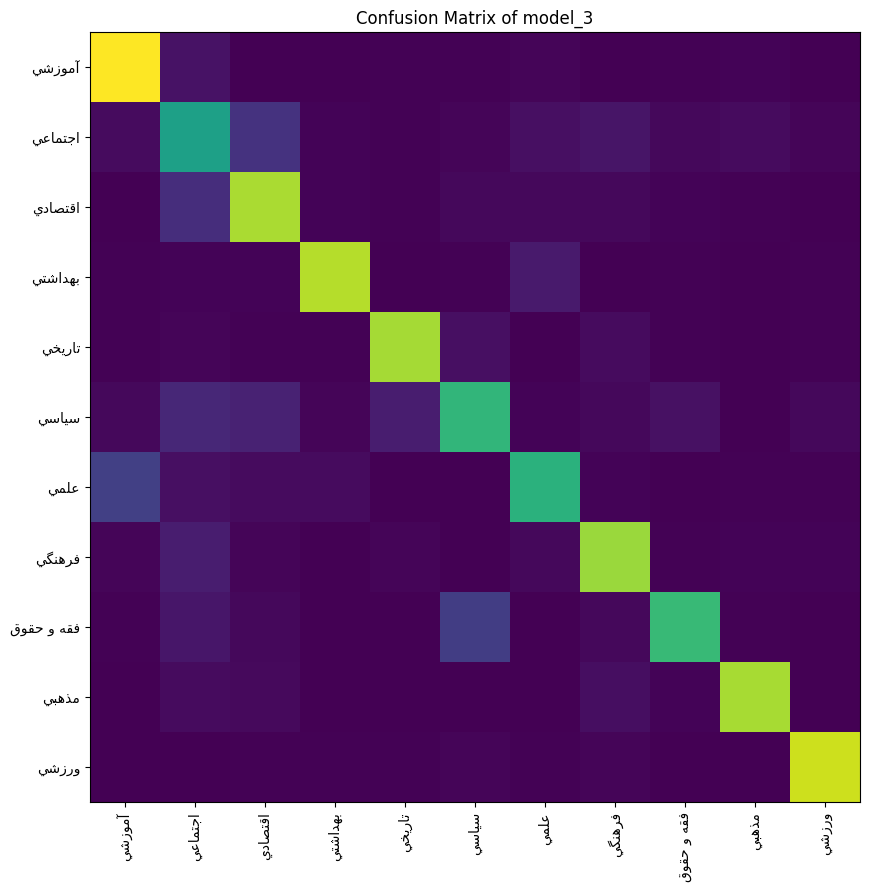

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=test_label_predict, y_true=val_label))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of model_3')
plt.show();

#### model_4

In [37]:
history_4 = model_4.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.2665 - f1_score: 0.4878 - loss: 2.0133 - val_accuracy: 0.7149 - val_f1_score: 0.6974 - val_loss: 0.8574
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7435 - f1_score: 0.7343 - loss: 0.8129 - val_accuracy: 0.7344 - val_f1_score: 0.7232 - val_loss: 0.8929
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.8406 - f1_score: 0.8371 - loss: 0.5495 - val_accuracy: 0.8017 - val_f1_score: 0.8035 - val_loss: 0.7187
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.8842 - f1_score: 0.8834 - loss: 0.4057 - val_accuracy: 0.8004 - val_f1_score: 0.8032 - val_loss: 0.7593
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9236 - f1_score: 0.9231 - loss: 0.2690 - val_accuracy: 0.8145 - val_f1_score: 0.8159 - val_loss: 0.6978


In [38]:
loss, accuracy, f1 = model_4.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8214 - f1_score: 0.8230 - loss: 0.6546
Final loss :0.70 
Final accuracy 0.81 
Final f1 0.82


In [39]:
train_label_predict = np.argmax(model_4.predict(train_ds), axis=1)
print('model_4 result on train data\n', classification_report(y_pred=train_label_predict, y_true=train_label))

138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step
model_4 result on train data
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       783
           1       0.95      0.93      0.94       814
           2       0.98      0.97      0.98       782
           3       0.95      1.00      0.97       801
           4       0.99      0.98      0.99       805
           5       0.92      0.94      0.93       786
           6       0.98      0.96      0.97       811
           7       0.96      0.97      0.96       797
           8       0.98      0.94      0.96       808
           9       0.98      1.00      0.99       807
          10       1.00      0.99      1.00       806

    accuracy                           0.97      8800
   macro avg       0.97      0.97      0.97      8800
weighted avg       0.97      0.97      0.97      8800



In [40]:
test_label_predict = np.argmax(model_4.predict(val_ds), axis=1)
print('model_4 result on test data\n', classification_report(y_pred=test_label_predict, y_true=val_label))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
model_4 result on test data
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       217
           1       0.56      0.61      0.58       186
           2       0.79      0.77      0.78       218
           3       0.84      0.94      0.89       199
           4       0.92      0.86      0.89       194
           5       0.64      0.74      0.69       214
           6       0.79      0.71      0.75       189
           7       0.82      0.82      0.82       203
           8       0.87      0.76      0.81       192
           9       0.91      0.94      0.93       193
          10       0.96      0.96      0.96       194

    accuracy                           0.81      2199
   macro avg       0.82      0.81      0.82      2199
weighted avg       0.82      0.81      0.82      2199



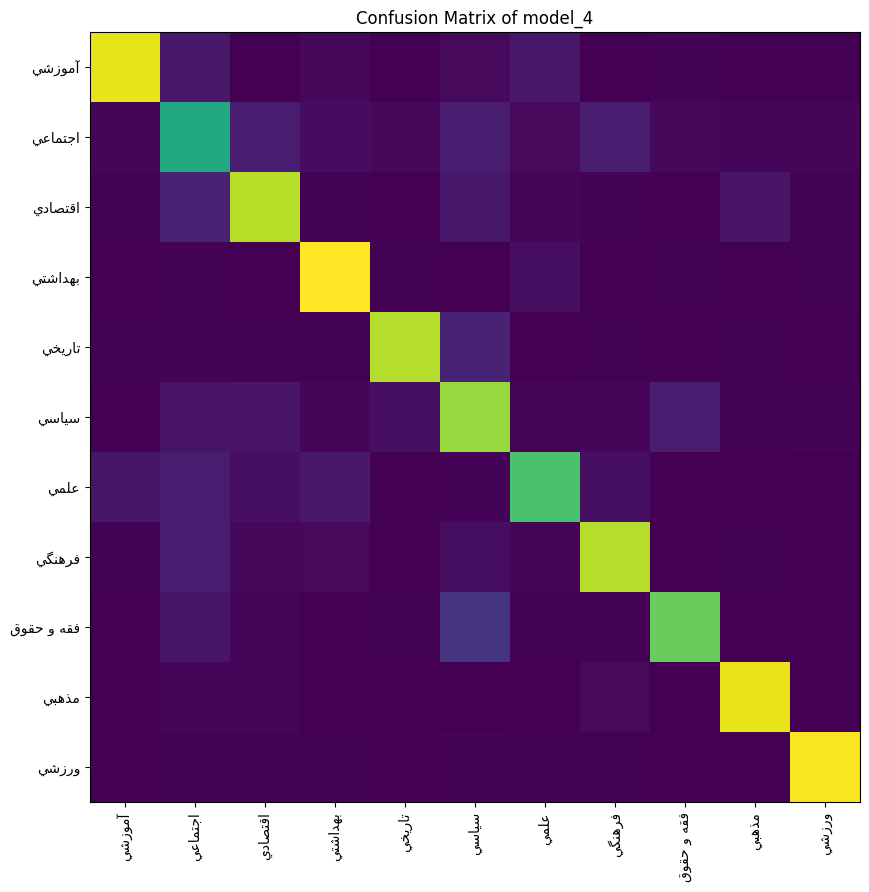

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=test_label_predict, y_true=val_label))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of model_4')
plt.show();

#### mdoel_5

In [42]:
history_5 = model_5.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step - accuracy: 0.2474 - f1_score: 0.4889 - loss: 2.0499 - val_accuracy: 0.7112 - val_f1_score: 0.6872 - val_loss: 0.8905
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.7188 - f1_score: 0.7069 - loss: 0.8755 - val_accuracy: 0.7763 - val_f1_score: 0.7762 - val_loss: 0.7360
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.8429 - f1_score: 0.8395 - loss: 0.5672 - val_accuracy: 0.7772 - val_f1_score: 0.7728 - val_loss: 0.8583
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.9039 - f1_score: 0.9027 - loss: 0.3846 - val_accuracy: 0.7744 - val_f1_score: 0.7771 - val_loss: 0.9706
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.9306 - f1_score: 0.9299 - loss: 0.2796 - val_accuracy: 0.7613 - val_f1_score: 0.7656 - val_loss: 0.9744


In [43]:
loss, accuracy, f1 = model_5.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7635 - f1_score: 0.7685 - loss: 0.9392
Final loss :0.97 
Final accuracy 0.76 
Final f1 0.77


In [44]:
train_label_predict = np.argmax(model_5.predict(train_ds), axis=1)
print('model_5 result on train data\n', classification_report(y_pred=train_label_predict, y_true=train_label))

138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step
model_5 result on train data
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       783
           1       0.90      0.90      0.90       814
           2       0.98      0.96      0.97       782
           3       0.98      0.98      0.98       801
           4       0.99      0.99      0.99       805
           5       0.83      0.93      0.87       786
           6       0.96      0.91      0.94       811
           7       0.97      0.82      0.88       797
           8       0.97      0.97      0.97       808
           9       0.98      0.97      0.98       807
          10       0.98      1.00      0.99       806

    accuracy                           0.95      8800
   macro avg       0.95      0.95      0.95      8800
weighted avg       0.95      0.95      0.95      8800



In [45]:
test_label_predict = np.argmax(model_5.predict(val_ds), axis=1)
print('model_5 result on test data\n', classification_report(y_pred=test_label_predict, y_true=val_label))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
model_5 result on test data
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       217
           1       0.47      0.65      0.54       186
           2       0.80      0.75      0.77       218
           3       0.92      0.84      0.88       199
           4       0.88      0.87      0.87       194
           5       0.53      0.70      0.61       214
           6       0.72      0.64      0.68       189
           7       0.74      0.52      0.61       203
           8       0.83      0.72      0.77       192
           9       0.92      0.85      0.89       193
          10       0.99      0.91      0.95       194

    accuracy                           0.76      2199
   macro avg       0.78      0.76      0.77      2199
weighted avg       0.78      0.76      0.77      2199



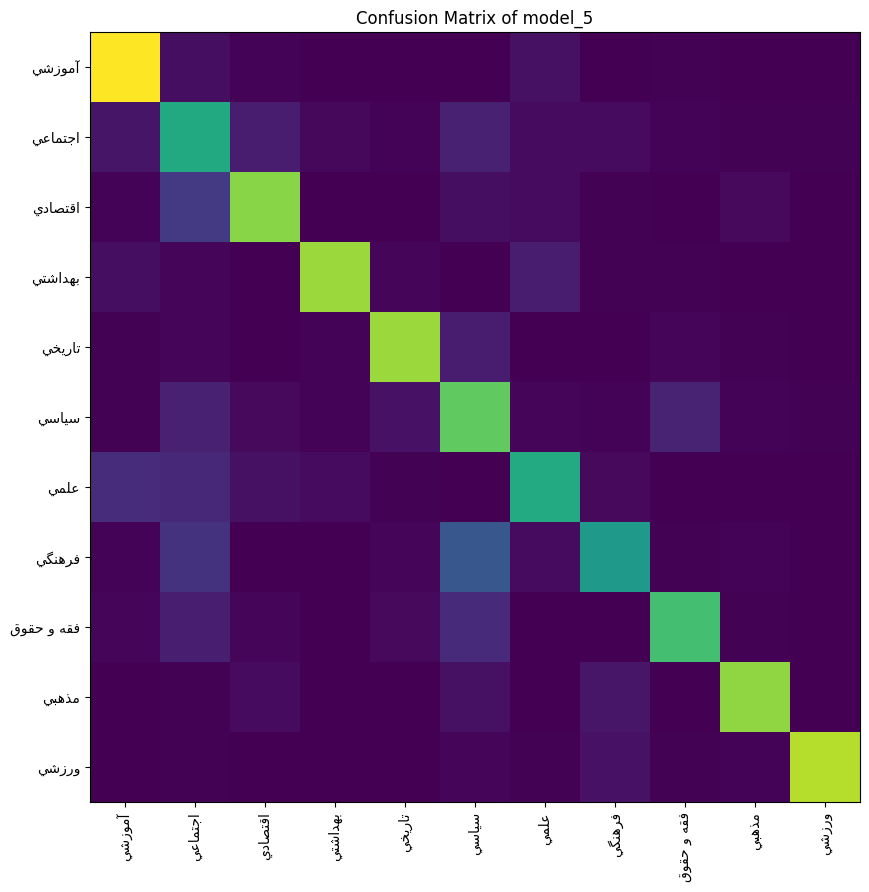

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=test_label_predict, y_true=val_label))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of model_5')
plt.show();

#### model_6

In [47]:
history_6 = model_6.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5


I0000 00:00:1713783346.364197     840 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 196 bytes spill stores, 196 bytes spill loads

I0000 00:00:1713783353.989188     840 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16', 1724 bytes spill stores, 1724 bytes spill loads

I0000 00:00:1713783363.372132      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 4 bytes spill loads



137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3040 - f1_score: 0.5025 - loss: 2.0303

I0000 00:00:1713783406.838029     869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_16', 1724 bytes spill stores, 1724 bytes spill loads

I0000 00:00:1713783409.638677     868 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_79', 196 bytes spill stores, 196 bytes spill loads



138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3053 - f1_score: 0.5028 - loss: 2.0269

I0000 00:00:1713783417.458981      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1713783427.064109     901 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 196 bytes spill stores, 196 bytes spill loads



138/138 ━━━━━━━━━━━━━━━━━━━━ 98s 473ms/step - accuracy: 0.3066 - f1_score: 0.5030 - loss: 2.0235 - val_accuracy: 0.7635 - val_f1_score: 0.7576 - val_loss: 0.7428
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.7851 - f1_score: 0.7817 - loss: 0.7426 - val_accuracy: 0.8172 - val_f1_score: 0.8160 - val_loss: 0.6901
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step - accuracy: 0.8799 - f1_score: 0.8795 - loss: 0.4482 - val_accuracy: 0.8249 - val_f1_score: 0.8220 - val_loss: 0.8289
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.9239 - f1_score: 0.9235 - loss: 0.2948 - val_accuracy: 0.8217 - val_f1_score: 0.8214 - val_loss: 0.8600
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 33s 237ms/step - accuracy: 0.9516 - f1_score: 0.9515 - loss: 0.2084 - val_accuracy: 0.7931 - val_f1_score: 0.7982 - val_loss: 1.1509


In [48]:
loss, accuracy, f1 = model_6.evaluate(val_ds)
print('Final loss :{:.2f} \nFinal accuracy {:.2f} \nFinal f1 {:.2f}'.format(loss, accuracy, f1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8030 - f1_score: 0.8077 - loss: 1.0903
Final loss :1.15 
Final accuracy 0.79 
Final f1 0.80


In [49]:
train_label_predict = np.argmax(model_6.predict(train_ds), axis=1)
print('model_6 result on train data\n', classification_report(y_pred=train_label_predict, y_true=train_label))

138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step
model_6 result on train data
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       783
           1       0.95      0.97      0.96       814
           2       0.97      0.98      0.97       782
           3       0.99      0.99      0.99       801
           4       0.99      0.99      0.99       805
           5       0.93      0.97      0.95       786
           6       0.97      0.97      0.97       811
           7       0.98      0.98      0.98       797
           8       0.99      0.96      0.97       808
           9       0.99      0.96      0.98       807
          10       0.99      0.98      0.99       806

    accuracy                           0.98      8800
   macro avg       0.98      0.98      0.98      8800
weighted avg       0.98      0.98      0.98      8800



In [50]:
test_label_predict = np.argmax(model_6.predict(val_ds), axis=1)
print('model_6 result on test data\n', classification_report(y_pred=test_label_predict, y_true=val_label))

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
model_6 result on test data
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       217
           1       0.48      0.68      0.57       186
           2       0.76      0.77      0.76       218
           3       0.93      0.88      0.90       199
           4       0.87      0.87      0.87       194
           5       0.67      0.71      0.69       214
           6       0.77      0.76      0.77       189
           7       0.78      0.75      0.77       203
           8       0.89      0.70      0.78       192
           9       0.97      0.81      0.88       193
          10       0.96      0.90      0.93       194

    accuracy                           0.79      2199
   macro avg       0.81      0.79      0.80      2199
weighted avg       0.81      0.79      0.80      2199



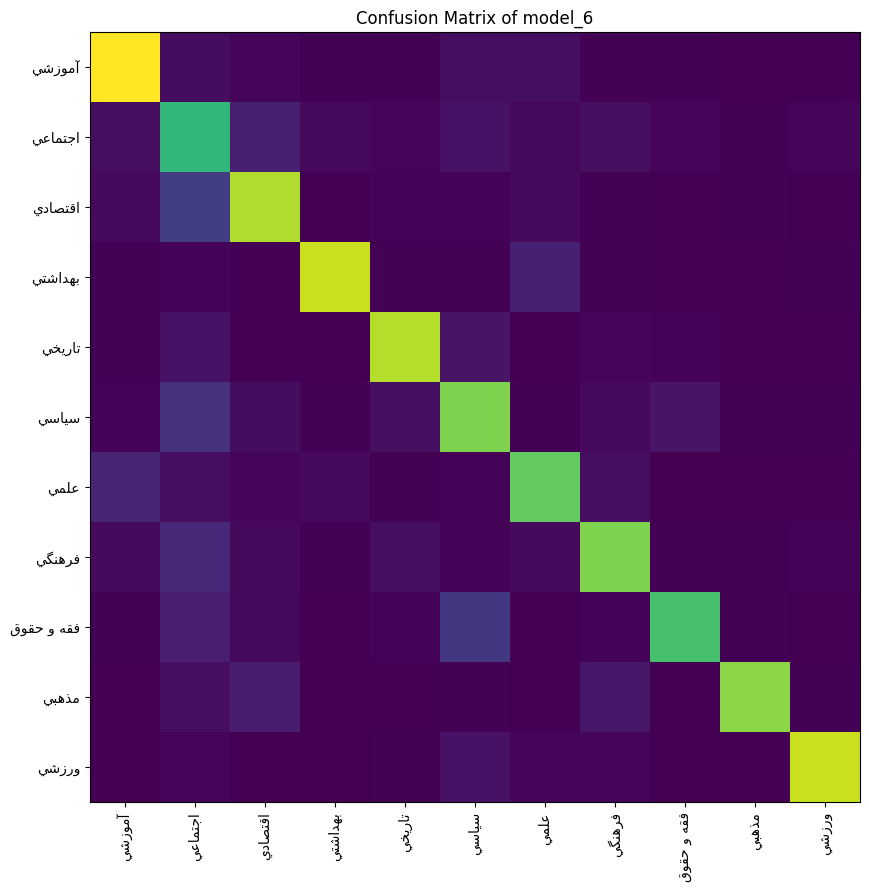

In [51]:
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_pred=test_label_predict, y_true=val_label))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], rotation=90, labels=labels)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=labels)
plt.title('Confusion Matrix of model_6')
plt.show();

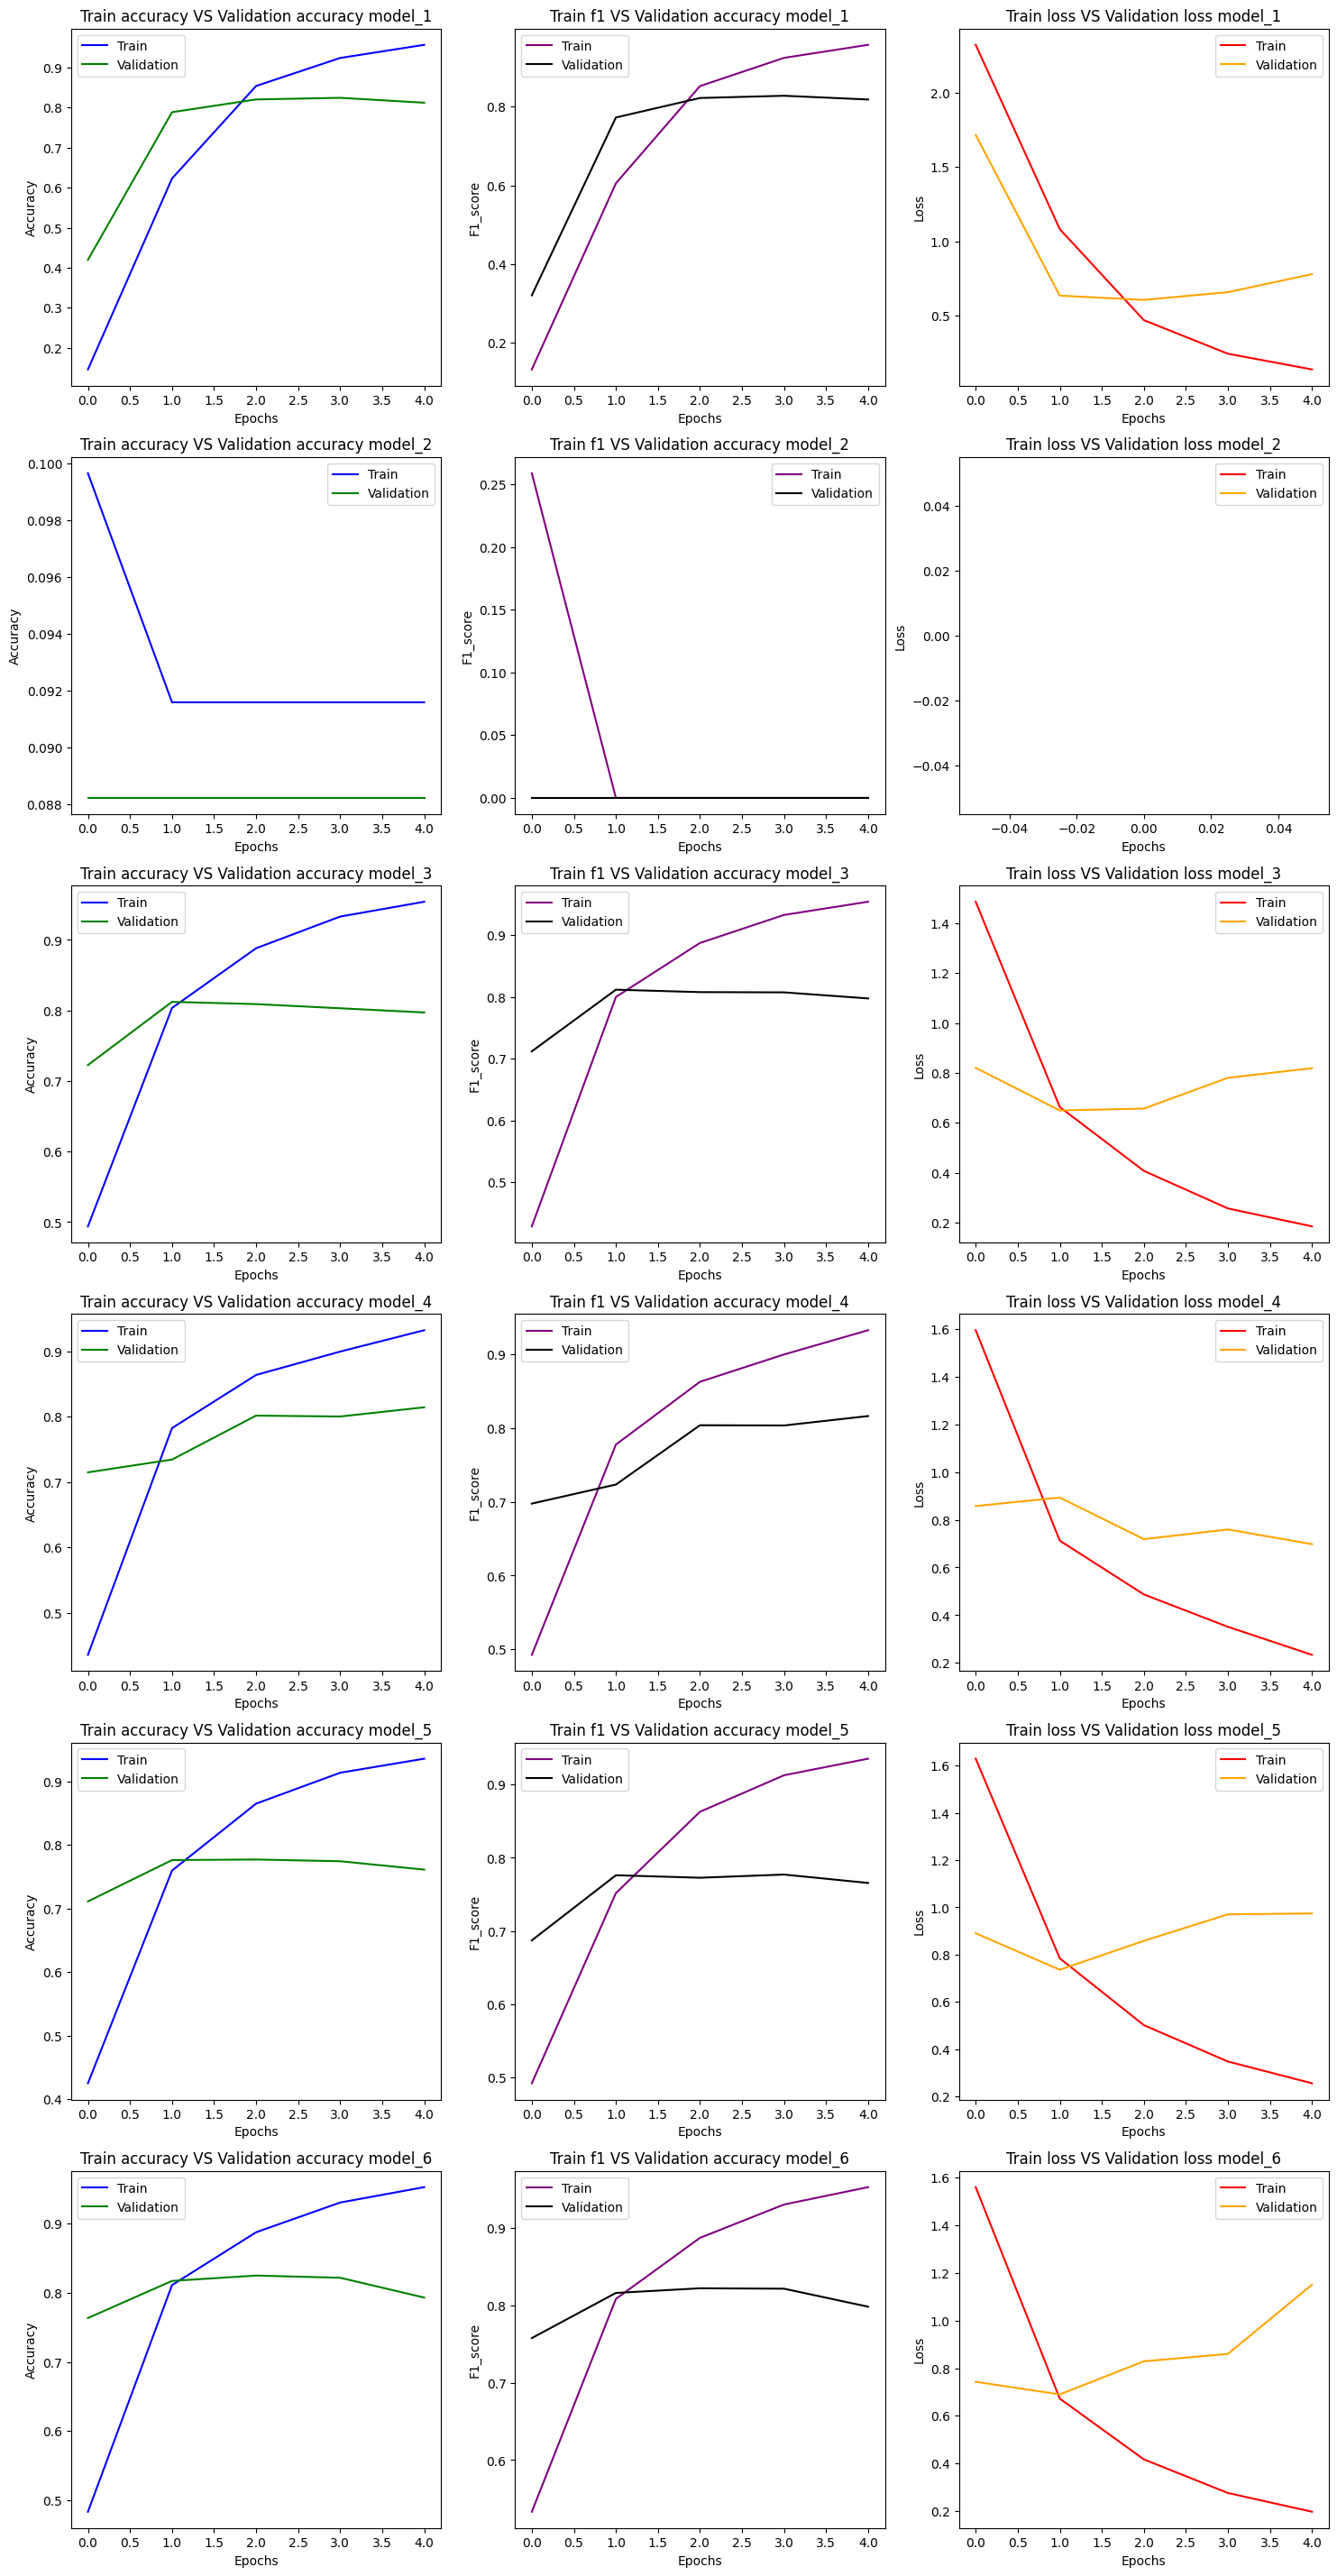

In [52]:
plt.figure(figsize=(18, 36))
plt.subplot(6, 3, 1)
plt.plot(history_1.history['accuracy'], c='blue', label='Train')
plt.plot(history_1.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_1')
plt.legend()
plt.subplot(6, 3, 2)
plt.plot(history_1.history['f1_score'], c='purple', label='Train')
plt.plot(history_1.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_1')
plt.legend()
plt.subplot(6, 3, 3)
plt.plot(history_1.history['loss'], c='red', label='Train')
plt.plot(history_1.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_1')
plt.legend()

plt.subplot(6, 3, 4)
plt.plot(history_2.history['accuracy'], c='blue', label='Train')
plt.plot(history_2.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_2')
plt.legend()
plt.subplot(6, 3, 5)
plt.plot(history_2.history['f1_score'], c='purple', label='Train')
plt.plot(history_2.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_2')
plt.legend()
plt.subplot(6, 3, 6)
plt.plot(history_2.history['loss'], c='red', label='Train')
plt.plot(history_2.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_2')
plt.legend()

plt.subplot(6, 3, 7)
plt.plot(history_3.history['accuracy'], c='blue', label='Train')
plt.plot(history_3.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_3')
plt.legend()
plt.subplot(6, 3, 8)
plt.plot(history_3.history['f1_score'], c='purple', label='Train')
plt.plot(history_3.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_3')
plt.legend()
plt.subplot(6, 3, 9)
plt.plot(history_3.history['loss'], c='red', label='Train')
plt.plot(history_3.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_3')
plt.legend()

plt.subplot(6, 3, 10)
plt.plot(history_4.history['accuracy'], c='blue', label='Train')
plt.plot(history_4.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_4')
plt.legend()
plt.subplot(6, 3, 11)
plt.plot(history_4.history['f1_score'], c='purple', label='Train')
plt.plot(history_4.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_4')
plt.legend()
plt.subplot(6, 3, 12)
plt.plot(history_4.history['loss'], c='red', label='Train')
plt.plot(history_4.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_4')
plt.legend()

plt.subplot(6, 3, 13)
plt.plot(history_5.history['accuracy'], c='blue', label='Train')
plt.plot(history_5.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_5')
plt.legend()
plt.subplot(6, 3, 14)
plt.plot(history_5.history['f1_score'], c='purple', label='Train')
plt.plot(history_5.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_5')
plt.legend()
plt.subplot(6, 3, 15)
plt.plot(history_5.history['loss'], c='red', label='Train')
plt.plot(history_5.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_5')
plt.legend()

plt.subplot(6, 3, 16)
plt.plot(history_6.history['accuracy'], c='blue', label='Train')
plt.plot(history_6.history['val_accuracy'], c='green', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train accuracy VS Validation accuracy model_6')
plt.legend()
plt.subplot(6, 3, 17)
plt.plot(history_6.history['f1_score'], c='purple', label='Train')
plt.plot(history_6.history['val_f1_score'], c='black', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.title('Train f1 VS Validation accuracy model_6')
plt.legend()
plt.subplot(6, 3, 18)
plt.plot(history_6.history['loss'], c='red', label='Train')
plt.plot(history_6.history['val_loss'], c='orange', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss VS Validation loss model_6')
plt.legend();